# Homework 11

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date:** Saturday, December 1st, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

**Joe Davison<br>
Anna Davydova<br>
Michael S. Emanuel<br>
Dylan Randle**

<div class="answer-separator">
------------------------
</div>

In [1]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm

import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
# Additional imports
import pymc3 as pm
import pickle
from IPython.display import display, HTML
import warnings
from typing import Dict

In [3]:
# Serialization
def load_vartbl(fname: str) -> Dict:
    """Load a dictionary of variables from a pickled file"""
    try:
        with open(fname, 'rb') as fh:
            vartbl = pickle.load(fh)
    except:
        vartbl = dict()
    return vartbl


def save_vartbl(vartbl: Dict, fname: str) -> None:
    """Save a dictionary of variables to the given file with pickle"""
    with open(fname, 'wb') as fh:
        pickle.dump(vartbl, fh)

# Load persisted table of variables
fname: str = 'census_income.pickle'
vartbl: Dict = load_vartbl(fname)

In [4]:
# Set plot style
matplotlib.rcParams.update({'font.size': 20})

# Turn off deprecation warning triggered by theano
warnings.simplefilter('ignore')

## Question 1: Crazy Rich Bayesians Don't Need No Educations?

**coding required**

In this problem, you will explore how to recast data, tasks and research questions from a variety of different contexts so that an existing model can be applied for analysis.

Example 10.1.3 in ["Statistical Rethinking"](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjopa0chtr7ns%2FStatistical_Rethinking_excerpt.pdf), the excerpt of which is included with this assignment, illustrates a study of the effect of an applicant's gender on graduate school admissions to six U.C. Berkeley departments through a comparison of four models. 

In this problem, you are given data from the [1994 U.S. Census](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjop9zvsjoscq%2Fcensus_data.csv). The data has been processed so that only a subset of the features are present (for full dataset as well as the description see the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Census+Income)). You will be investigate the effect of gender on a person's yearly income in the dataset. In particular, we want to know how a person's gender effect the likelihood of their yearly salary being above or below \$50k. 

1.1. Read the dataset into a dataframe and aggregate the dataset by organizing the  dataframe into seven different categories. 

The categories we wish to consider are: 
* 4 year college degree
* Some-college or two year academic college degree
* High school
* Professional, vocational school
* Masters 
* Doctorate
* Some or no high school

Note that you might have to combine some of the existing education categories in your dataframe. For each category, we suggest that you only keep track of a count of the number of males and females who make above (and resp. below) the crazy rich income of $50k (see the dataset in Example 10.1.3). 

1.2. Following Example 10.1.3, build two models for the classification of an individual's yearly income (1 being above \$50k and 0 being below), one of these models should include the effect of gender while the other should not. 

1.3. Replicate the analysis in 10.1.3 using your models; specifically, compute wAIC scores and make a plot like Figure 10.5 (posterior check) to see how well your models fits the data. 

1.4. Following Example 10.1.3, build two models for the classification of an individual's yearly income taking into account education. One of the models should take into account education only the other should take into account gender and education on income.

1.5. Replicate the analysis in 10.1.3 using your models; specifically, compute wAIC scores and make a plot like Figure 10.6 (posterior check) to see how well your model fits the data.

1.6. Using your analysis from 1.3, discuss the effect gender has on income.

1.7. Using your analysis from 1.5, discuss the effect of gender on income taking into account an individual's education.

(**Hint: If you haven't seen WAIC, it's because we'll be covering it on Monday November 26, 2018.  In the meantime checkout info about WAIC in this resource on [PyMC3 model selection](https://docs.pymc.io/notebooks/model_comparison.html).**)

**1.1** 1.1. Read the dataset into a dataframe and aggregate the dataset by organizing the dataframe into seven different categories.

In [5]:
def load_data():
    """Load data and aggregate it by education and sex"""

    # Read in the full dataframe
    df_full = pd.read_csv('census_data.csv', index_col=0)
    
    # Map from census education categories to new categories
    education_map = {
        'Preschool' : 'Not-HS-Grad',
        '1st-4th' : 'Not-HS-Grad',
        '5th-6th' : 'Not-HS-Grad',
        '7th-8th' : 'Not-HS-Grad',
        '9th' : 'Not-HS-Grad',
        '10th' : 'Not-HS-Grad',
        '11th' : 'Not-HS-Grad',
        '12th' : 'Not-HS-Grad',
        'HS-grad': 'HS-Grad',
        'Some-college': 'College-Lite',
        'Assoc-acdm': 'College-Lite',
        'Assoc-voc': 'Prof-Voc',
        'Prof-school': 'Prof-Voc',
        'Bachelors': 'Bachelors',
        'Masters': 'Masters',
        'Doctorate': 'Doctorate'
        }
    
    educationID_map = {
        'Not-HS-Grad': 0,
        'HS-Grad': 1,
        'College-Lite': 2,
        'Prof-Voc': 3,
        'Bachelors': 4,
        'Masters': 5,
        'Doctorate': 6
    }
    
    sexID_map = {
            'Male' : 0,
            'Female' : 1
    }
    
    # Map from census income to a float (1.0 for high earning)
    earning_map =  {
        '<=50K': 0.0,
        '>50K': 1.0}
    
    # New series for education and earnings
    education = pd.Series(df_full.edu.map(education_map), name='education')
    education_id = pd.Series(education.map(educationID_map), name='education_id', dtype='category')
    # We also want the sex
    sex = df_full.sex
    sex_id = pd.Series(sex.map(sexID_map), name='sex_id', dtype='category')
    # The earnings (trying to predict this)
    earn_hi = pd.Series(df_full.earning.map(earning_map), name='earn_hi', dtype=np.int64)
    
    # Create a new dataframe
    df = pd.concat([education_id, sex_id, education, sex, earn_hi], axis=1, 
                   names=['education_id', 'sex_id', 'education', 'sex', 'earn_hi'])    
    # Aggregate counts of high and low earners by education for males and females as per hint
    # For each category, we suggest that you only keep track of a count of the number of males and females 
    # who make above (and resp. below) the crazy rich income of $50k (see the dataset in Example 10.1.3).
    # https://stackoverflow.com/questions/19384532/how-to-count-number-of-rows-per-group-and-other-statistics-in-pandas-group-by
    gb = df.groupby(by=[education_id, sex_id])
    counts = gb.size().to_frame(name='count')
    df_agg = counts.join(gb.agg({'earn_hi': 'sum'})).reset_index()
    # Change count column to 32 bit integer for compatibility with pymc3 sampling
    df_agg['count'] = df_agg['count'].astype(np.int32)
    # Add indicators is_male, is_female
    df_agg['is_male'] = np.zeros_like(df_agg.education_id, dtype=float)
    df_agg['is_female'] = np.zeros_like(df_agg.education_id, dtype=float)
    # High earning rate in each category
    df_agg['earn_hi_rate'] = df_agg['earn_hi'] / df_agg['count']
    # Return the dataframe    
    return df_agg, educationID_map, sexID_map

In [6]:
df, educationID_map, sexID_map = load_data()
display(df)

,education_id,sex_id,count,earn_hi,is_male,is_female,earn_hi_rate
0,0,0,2932,221,0.0,0.0,0.075375
1,0,1,1321,23,0.0,0.0,0.017411
2,1,0,7111,1449,0.0,0.0,0.203769
3,1,1,3390,226,0.0,0.0,0.066667
4,2,0,5131,1399,0.0,0.0,0.272656
5,2,1,3227,253,0.0,0.0,0.078401
6,3,0,1366,675,0.0,0.0,0.494143
7,3,1,592,109,0.0,0.0,0.184122
8,4,0,3736,1882,0.0,0.0,0.503747
9,4,1,1619,339,0.0,0.0,0.209389


**1.2** Following Example 10.1.3, build two models for the classification of an individual's yearly income (1 being above $50k and 0 being below), one of these models should include the effect of gender while the other should not.

In [7]:
# Shared configuration for all models in 1.2 & 1.4
# Number of educational categories
num_sex: int = len(sexID_map)
num_edu: int = len(educationID_map)

# Size for models
num_obs: int = len(df)

# Mean and Standard Deviation of distribution for alpha (constant term)
alpha_mu: float = 0.0
alpha_sd: float = 10.0

# Mean and Standard Deviation of distribution for beta (impact of sex on likelihood of high earnings)
beta_sex_mu: float = 0.0
beta_sex_sd: float = 10.0

# Mean and Standard Deviation of distribution for alpha by eductation
beta_edu_mu: float = 0.0
beta_edu_sd: float = 10.0

# The number of samples to draw
num_samples: int = 100000

In [8]:
# Create a baseline model with just a constant; name it model_base
with pm.Model() as model_base:
    # The alpha shared by all categories
    alpha = pm.Normal(name='alpha', mu=alpha_mu, sd=alpha_sd)
    # The logit for each category
    logit_p = pm.Deterministic('logit_p', alpha)
    # The probability follows logit(p_i) ~ alpha_i --> p_i ~ invlogit(alpha_i)
    p = pm.Deterministic('p', pm.math.invlogit(logit_p))
    # Data likelihood
    obs_earn = pm.Binomial('obs_earn', n=df['count'].values, p=p, observed=df['earn_hi'].values)

# Draw samples from model_base
try:
    trace_base = vartbl['trace_base']
    print(f'Loaded trace_base from variable table in {fname}.')
except:    
    with model_base:
        # Need to manually specify cores=1 or this blows up on windows.
        # this is a a known bug on pymc3
        # https://github.com/pymc-devs/pymc3/issues/3140
        trace_base = pm.sample(10000, chains=2, cores=1)
    vartbl['trace_base'] = trace_base
    save_vartbl(vartbl, fname)

Loaded trace_base from variable table in census_income.pickle.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014173976128>,
      dtype=object)

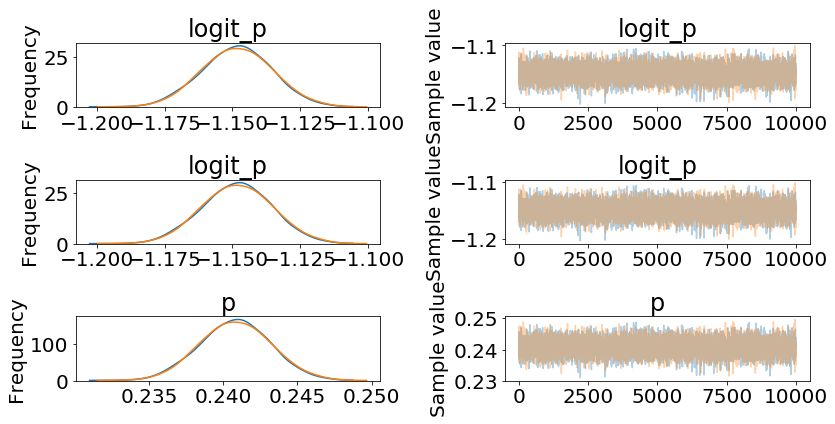

In [9]:
# Review outputs of model_base
display(pm.traceplot(trace_base))

In [10]:
# Create a model using only sex; name it model_sex
with pm.Model() as model_sex:
    # The beta for the two sex categories
    beta_sex = pm.Normal(name='beta_sex', mu=beta_sex_mu, sd=beta_sex_sd, shape=num_sex)
    # The logit for each category
    logit_p = pm.Deterministic('logit_p', beta_sex[df.sex_id])
    # The probability follows logit(p_i) ~ alpha_i --> p_i ~ invlogit(alpha_i)
    p = pm.Deterministic('p', pm.math.invlogit(logit_p))
    # Data likelihood
    obs_earn = pm.Binomial('obs_earn', n=df['count'].values, p=p, observed=df['earn_hi'].values)

# Draw samples from model_sex
try:
    trace_sex = vartbl['trace_sex']
    print(f'Loaded trace_sex from variable table in {fname}.')
except:    
    with model_sex:
        trace_sex = pm.sample(10000, chains=2, cores=1)
    vartbl['trace_sex'] = trace_sex
    save_vartbl(vartbl, fname)

Loaded trace_sex from variable table in census_income.pickle.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014173E18978>,
      dtype=object)

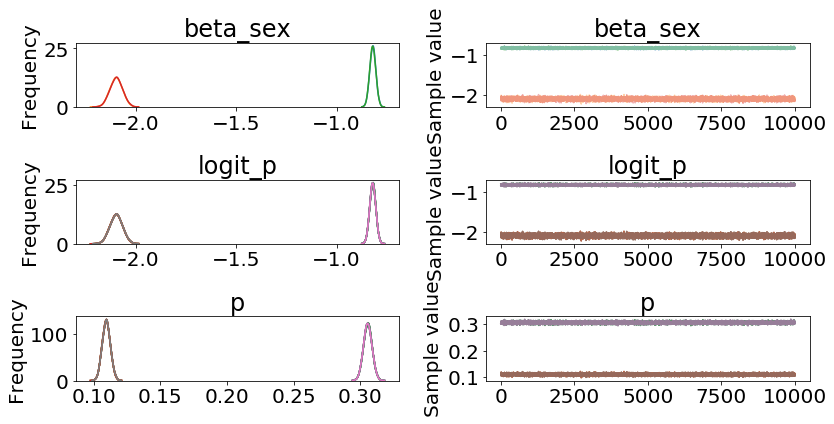

In [11]:
# Review outputs of model_sex
display(pm.traceplot(trace_sex))

**1.3**. Replicate the analysis in 10.1.3 using your models; specifically, compute wAIC scores and make a plot like Figure 10.5 (posterior check) to see how well your models fits the data.

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
sex,4647.35,489.24,0,0.52,1181.09,0,1
base,6184.66,404.91,1537.31,0.48,1588.8,1379.92,1


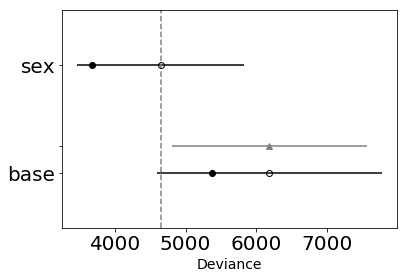

In [12]:
# Compute WAIC for both models
waic_base = pm.waic(trace_base, model_base)
waic_sex = pm.waic(trace_sex, model_sex)
# Set model names
model_base.name = 'base'
model_sex.name = 'sex'
# Comparison of WAIC
comp_WAIC_base_v_sex = pm.compare({model_base: trace_base, model_sex: trace_sex})
display(comp_WAIC_base_v_sex)
pm.compareplot(comp_WAIC_base_v_sex)

In [13]:
def plot_posterior(HER_data, HER_mean, HER_lo, HER_hi, model_name):
    """Generate the posterior validation plot following the example in Statistical Rethinking"""
    fig, ax = plt.subplots(figsize=[16,8])
    ax.set_title(f'Posterior Validation Check for {model_name} Model')
    # x axis for plots
    xx = np.arange(num_obs)
    ax.set_xticks(xx)
    ax.set_xlabel('Case')
    ax.set_ylabel('High Earning Rate (Above $50k)')

    # Actual data
    p1 = ax.plot(xx, HER_data, marker='o', color='b', markersize=8, linewidth=0, label='Data')
    # Lines between consecutive male / female pairs
    for i in range(num_obs // 2):
        i0 = 2*i
        i1 = i0+2
        ax.plot(xx[i0:i1], HER_data[i0:i1], marker=None, color='b')
    # Mean, Lo, and Hi model estimates
    p2 = ax.plot(xx, HER_lo, marker='_', color='k', markersize=10, linewidth=0, label='Low')
    p3 = ax.plot(xx, HER_mean, marker='o', color='r', markerfacecolor='None', markersize=10, linewidth=0, label='Mean')
    p4 = ax.plot(xx, HER_hi, marker='_', color='k', markersize=10, linewidth=0, label='High')
    # Vertical lines closing up whiskers
    for i in range(num_obs):
        ax.plot(np.array([i,i]), np.array([HER_lo[i], HER_hi[i]]), marker=None, color='k')

    # Legend
    handles = [p1[0], p2[0], p3[0], p4[0]]
    labels = ['Data', 'Low', 'Mean', 'High']
    ax.legend(handles, labels)
    ax.grid()
    plt.show()

In [14]:
# Generate the posterior predictive in both base and sex models
try:
    post_pred_base = vartbl['post_pred_base']
    post_pred_sex = vartbl['post_pred_sex']
    print(f'Loaded posterior predictive for base and sex models.')
except:
    with model_base:
        post_pred_base = pm.sample_ppc(trace_base)
    with model_sex:
        post_pred_sex = pm.sample_ppc(trace_sex)
    vartbl['post_pred_base'] = post_pred_base
    vartbl['post_pred_sex'] = post_pred_sex
    save_vartbl(vartbl, fname)

# True rate of high earners in each class
HER_data = df['earn_hi_rate'].values

# Mean, low (5.5th percentile), and high (94.5th percentile) estimates of high earning rate (HER) in base model
HER_mean_base = np.mean(post_pred_base['obs_earn'], axis=0) / df['count'].values
HER_lo_base = np.percentile(a=post_pred_base['obs_earn'],q=5.5, axis=0) / df['count'].values
HER_hi_base = np.percentile(a=post_pred_base['obs_earn'],q=94.5, axis=0) / df['count'].values

# HER in sex model
HER_mean_sex = np.mean(post_pred_sex['obs_earn'], axis=0) / df['count'].values
HER_lo_sex = np.percentile(a=post_pred_sex['obs_earn'],q=5.5, axis=0) / df['count'].values
HER_hi_sex = np.percentile(a=post_pred_sex['obs_earn'],q=94.5, axis=0) / df['count'].values

Loaded posterior predictive for base and sex models.


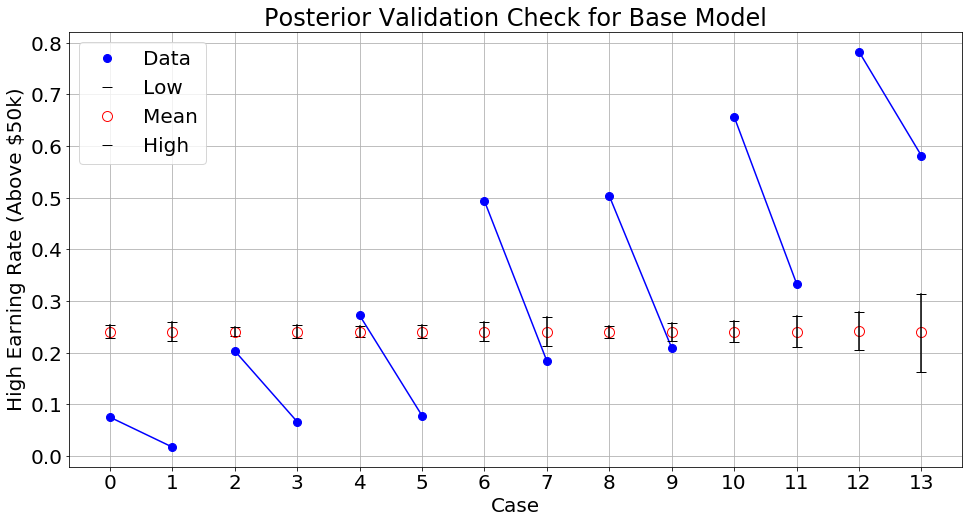

In [15]:
plot_posterior(HER_data, HER_mean_base, HER_lo_base, HER_hi_base, 'Base')

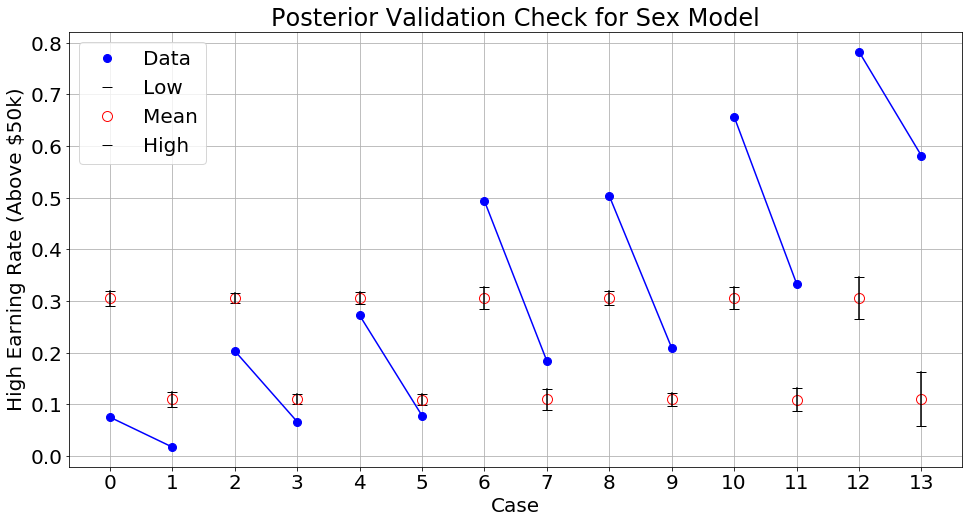

In [16]:
plot_posterior(HER_data, HER_mean_sex, HER_lo_sex, HER_hi_sex, 'Sex')

**1.4**. Following Example 10.1.3, build two models for the classification of an individual's yearly income taking into account education. One of the models should take into account education only the other should take into account gender and education on income.

In [17]:
# Create a model using only education; name it model_edu
with pm.Model() as model_edu:
    # The beta for each of the seven educational categories
    beta_edu = pm.Normal(name='beta_edu', mu=beta_edu_mu, sd=beta_edu_sd, shape=num_edu)
    # The logit for each category
    logit_p = pm.Deterministic('logit_p', beta_edu[df.education_id])
    # The probability follows logit(p_i) ~ alpha_i --> p_i ~ invlogit(alpha_i)
    p = pm.Deterministic('p', pm.math.invlogit(logit_p))
    # Data likelihood
    obs_earn = pm.Binomial('obs_earn', n=df['count'].values, p=p, observed=df['earn_hi'].values)

# Draw samples from model_edu
try:
    trace_edu = vartbl['trace_edu']
    print(f'Loaded trace_edu from {fname}.')
except:    
    with model_edu:
        trace_edu = pm.sample(10000, chains=2, cores=1)
    vartbl['trace_edu'] = trace_edu
    save_vartbl(vartbl, fname)

Loaded trace_edu from census_income.pickle.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001417763D5C0>,
      dtype=object)

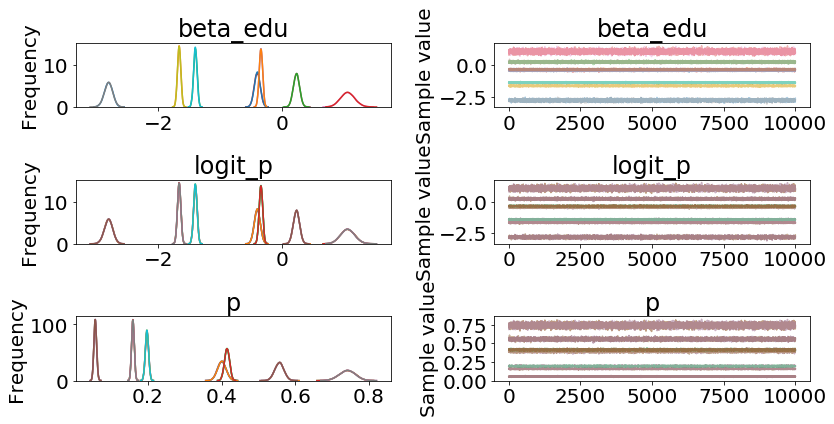

In [18]:
# Review outputs of model_edu
display(pm.traceplot(trace_edu))

In [19]:
# Create a model using both education and sex; name it model_edu_sex
with pm.Model() as model_edu_sex:
    # The beta for each of the seven educational categories
    beta_edu = pm.Normal(name='beta_edu', mu=beta_edu_mu, sd=beta_edu_sd, shape=num_edu)
    # The beta for the two sex categories
    beta_sex = pm.Normal(name='beta_sex', mu=beta_sex_mu, sd=beta_sex_sd, shape=num_sex)
    # The logit for each category
    logit_p = pm.Deterministic('logit_p', beta_edu[df.education_id] + beta_sex[df.sex_id])
    # The probability follows logit(p_i) ~ alpha_i --> p_i ~ invlogit(alpha_i)
    p = pm.Deterministic('p', pm.math.invlogit(logit_p))
    # Data likelihood
    obs_earn = pm.Binomial('obs_earn', n=df['count'].values, p=p, observed=df['earn_hi'].values)

# Draw samples from model_edu_sex
try:
    trace_edu_sex = vartbl['trace_edu_sex']
    print(f'Loaded trace_edu_sex from {fname}.')
except:    
    with model_edu_sex:
        model_edu_sex_trace = pm.sample(10000, chains=2, cores=1)
    vartbl['trace_edu_sex'] = trace_edu_sex
    save_vartbl(vartbl, fname)

Loaded trace_edu_sex from census_income.pickle.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014174FD8550>,
      dtype=object)

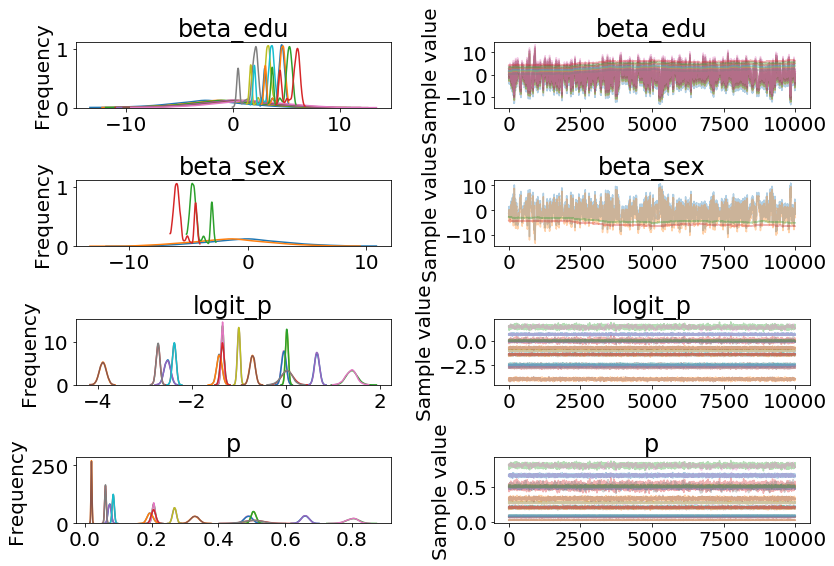

In [20]:
# Review outputs of model_edu_sex
display(pm.traceplot(trace_edu_sex))

**1.5**. Replicate the analysis in 10.1.3 using your models; specifically, compute wAIC scores and make a plot like Figure 10.6 (posterior check) to see how well your model fits the data.

In [21]:
# Compute WAIC for both models
waic_edu = pm.waic(trace_edu, model_edu)
waic_edu_sex = pm.waic(trace_edu_sex, model_edu_sex)
# Set model names
model_base.name = 'edu'
model_sex.name = 'edu_sex'
# Comparison of WAIC
comp_WAIC_edu_v_both = pm.compare({model_edu: trace_edu, model_edu_sex: trace_edu_sex})
display(comp_WAIC_edu_v_both)

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
1,123.21,6.1,0,1,5.64,0,1
0,2834.44,701.13,2711.23,0,584.82,581.8,1


In [22]:
# Generate the posterior predictive in both base and sex models
try:
    post_pred_edu = vartbl['post_pred_edu']
    post_pred_edu_sex = vartbl['post_pred_edu_sex']
    print(f'Loaded posterior predictive for edu and edu_sex models.')
except:
    with model_edu:
        post_pred_edu = pm.sample_ppc(trace_edu)
    with model_edu_sex:
        post_pred_edu_sex = pm.sample_ppc(trace_edu_sex)
    vartbl['post_pred_edu'] = post_pred_edu
    vartbl['post_pred_edu_sex'] = post_pred_edu_sex
    save_vartbl(vartbl, fname)

# Mean, low (5.5th percentile), and high (94.5th percentile) estimates of high earning rate (HER) in base model
HER_mean_edu = np.mean(post_pred_edu['obs_earn'], axis=0) / df['count'].values
HER_lo_edu = np.percentile(a=post_pred_edu['obs_earn'],q=5.5, axis=0) / df['count'].values
HER_hi_edu = np.percentile(a=post_pred_edu['obs_earn'],q=94.5, axis=0) / df['count'].values

# HER in sex model
HER_mean_edu_sex = np.mean(post_pred_edu_sex['obs_earn'], axis=0) / df['count'].values
HER_lo_edu_sex = np.percentile(a=post_pred_edu_sex['obs_earn'],q=5.5, axis=0) / df['count'].values
HER_hi_edu_sex = np.percentile(a=post_pred_edu_sex['obs_earn'],q=94.5, axis=0) / df['count'].values

Loaded posterior predictive for edu and edu_sex models.


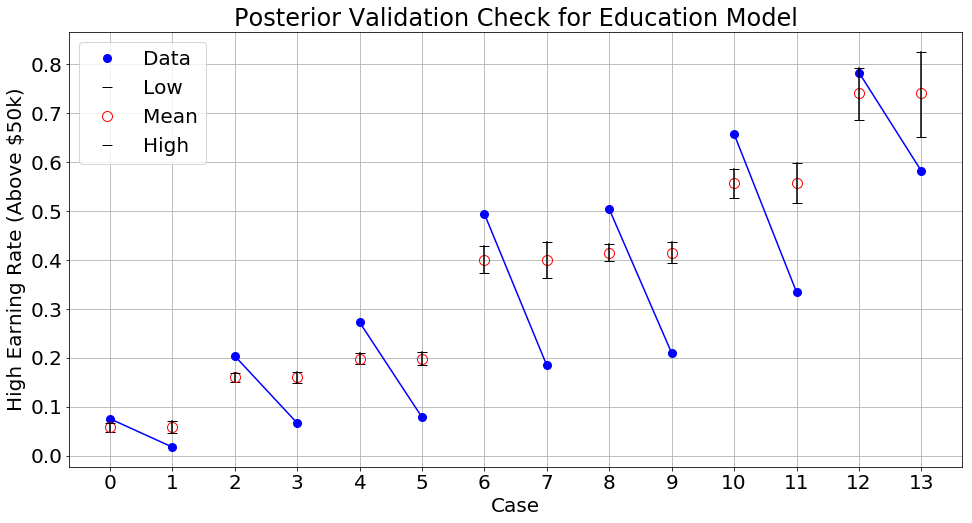

In [23]:
plot_posterior(HER_data, HER_mean_edu, HER_lo_edu, HER_hi_edu, 'Education')

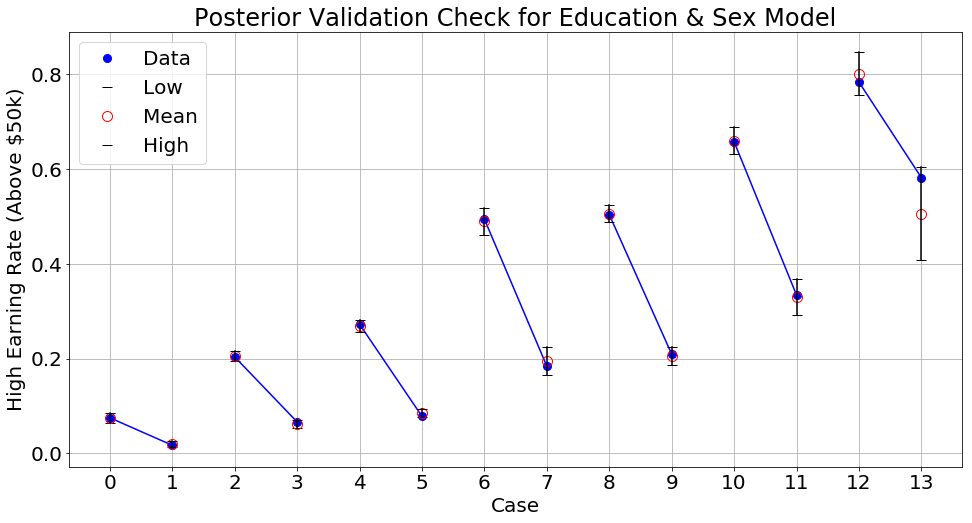

In [24]:
plot_posterior(HER_data, HER_mean_edu_sex, HER_lo_edu_sex, HER_hi_edu_sex, 'Education & Sex')

**1.6**. Using your analysis from 1.3, discuss the effect gender has on income.

In [25]:
pm.summary(trace_sex, varnames=['beta_sex', 'p'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_sex__0,-0.820011,0.014879,0.000089,-0.849283,-0.791063,21365.614354,1.000034
beta_sex__1,-2.096541,0.030792,0.000218,-2.157298,-2.037685,17572.456484,1.000171
p__0,0.305771,0.003158,0.000019,0.299583,0.311940,21361.073782,1.000034
p__1,0.109470,0.003001,0.000021,0.103651,0.115303,17582.695154,1.000176
p__2,0.305771,0.003158,0.000019,0.299583,0.311940,21361.073782,1.000034
p__3,0.109470,0.003001,0.000021,0.103651,0.115303,17582.695154,1.000176
p__4,0.305771,0.003158,0.000019,0.299583,0.311940,21361.073782,1.000034
p__5,0.109470,0.003001,0.000021,0.103651,0.115303,17582.695154,1.000176
p__6,0.305771,0.003158,0.000019,0.299583,0.311940,21361.073782,1.000034
p__7,0.109470,0.003001,0.000021,0.103651,0.115303,17582.695154,1.000176


In the analysis from 1.3, we considered two alternative models.  The baseline model made a single prediction for all 14 demographic groups that they had a 24.1\% probability of being high earners (above \\$50,000 / year).  The sex model took only one demographic variable into account.  It predicted that all males had a 30.6\% chance of being high earners and that all females had a 10.9 chance of being high earners.  The sex model is clearly a stronger model, and it is favored by the WAIC--though not overwhelmingly, because there is a large uncertainty in the parameter estimates.  The weightings are 52/48 in favor of the sex model.  The posterior validation check shows us at a quick glimpse that while the sex model fits the data better than the baseline, both models are a pretty poor fit for predicting the probability that a person earned over \$50,000 in 1994.  Just glancing at the pattern of the data, where the horizontal axis correlates with educational attainment, the pattern is clear that education is a stronger predictor than gender when predicting high income.  We can estimate the size of the effect by looking at the above summary from the trace of the sex model.  This shows that the difference is between -0.82 (males) and -2.09 (females) in logit space, corresponding to probabilities of about 10.9 and 30.6 percent, respectively.

My conlcusion is that gender has a real and measurable effect on the probability that someone in the 1994 census was a high earner, but that a model considering only sex is so weak that we should be reluctant to draw too many inferential conclusions without introducing additional variables that fit the data better.

**1.7**. Using your analysis from 1.5, discuss the effect of gender on income taking into account an individual's education.

In [26]:
pm.summary(trace_edu_sex, varnames=['beta_sex', 'beta_edu', 'p'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_sex__0,-2.143982,3.233705,0.228065,-5.773652,5.783717,1.975420,1.522568
beta_sex__1,-3.516916,3.233992,0.228082,-7.136439,4.426953,1.975651,1.522450
beta_edu__0,-0.379732,3.234625,0.228041,-8.259889,3.304650,1.976521,1.522164
beta_edu__1,0.795347,3.233828,0.228078,-7.163092,4.386539,1.975740,1.522484
beta_edu__2,1.141453,3.234194,0.228112,-6.818259,4.737191,1.975007,1.522712
beta_edu__3,2.101326,3.234873,0.228109,-5.807327,5.757355,1.975238,1.522690
beta_edu__4,2.164920,3.234140,0.228097,-5.786406,5.770180,1.975614,1.522530
beta_edu__5,2.805222,3.234179,0.228104,-5.170165,6.397952,1.974489,1.522817
beta_edu__6,3.538770,3.230461,0.227135,-4.357102,7.226929,1.986106,1.517950
p__0,0.074343,0.004583,0.000087,0.065443,0.083331,2636.394727,0.999951


In 1.5, we considered two models.  One predicted the rate of high earners using education alone, where education was compressed into seven categories as per the problem specification.  The second model took into account education and sex, assigning a beta weighting to each category.  The WAIC comparison shows that the two factor model incorporating sex and education is overwhelmingly superior to the model only incorporating education.  The pseudo-probability weightings between the two model are 100\% on the two factor model, 0\% on the education only model.  A quick look at the posterior predictive chart reaffirms that this model is doing a fine job on the data.  It is practically nailing 13 out of the 14 categories.  The only major error it makes is that it under-predicts the number of women holding doctoral degrees who are high earners.

I would add one word of caution however.  The number of effective parameters in the chart above is not nearly high enough, and Rhat parameter is too high.  I would like to spend more time tuning the sampling parameters to improve the quality of the samples.  But time is limited and this analysis is sufficient for the task at hand.

Given the quality of this fit, we are left with the sobering conclusion that in 1994, being female had a drastic effect on a person's probability of being a high earner.  For college graduates (categories 8 and 9 for men and women), we can see the men had a 50.5\% chance of high earnings compared to 20.6\% for women.  The numbers were similar for graduates of professional and vocational schools.  With a Masters degree, a man at this time had a 65.9\% chance of being high paid compared to just 32.9\% for women.  Finally for holders of doctoral degrees, the rates were 80\% for men and 50.5\% for women.

I do not believe that an analysis of this type is sufficient to form a firm conclusion about complex questions such as institutional sexism and the underpayment of women.  I would say that if you hold a simplified view of the labor market that a person's earning power is largely determined by their educational attainment, and that sex might also play a part, this analysis gives strong evidence that simply being female significantly hampered women's earnings prospects in 1994.

**Gratuitous Titular Reference**:  

If you haven't watched [Crazy Rich Asians](http://www.crazyrichasiansmovie.com/) then it might be time.

If you haven't listened to [Pink Floyd's](https://en.wikipedia.org/wiki/Pink_Floyd) [The Wall](https://en.wikipedia.org/wiki/The_Wall) then it might be time.

Also who are you? :-)

Anyway [You don't need no thought control](https://www.youtube.com/watch?v=YR5ApYxkU-U), [You probably want us teaching staff to leave you kids alone](https://www.youtube.com/watch?v=YR5ApYxkU-U), and [Education is overrated, right?  You don't need it!](https://www.youtube.com/watch?v=YR5ApYxkU-U)

## Question 2:  My Sister-In-Law's Baby Cousin Tracy ...

**pre-regression analysis**

In [27]:
# Load persisted table of variables
fname: str = 'gauss_process.pickle'
vartbl: Dict = load_vartbl(fname)

In [28]:
#load the data
survey = pd.read_csv('survey.csv')

Text(0.5, 1.0, "Responders' Age vs. % with at least one LGBTQ Acquaitance")

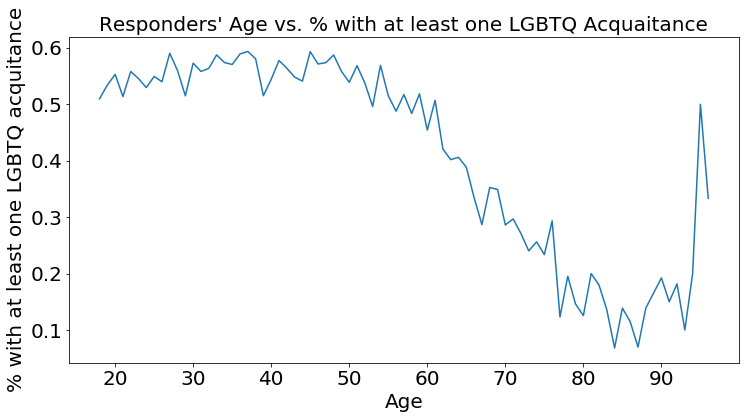

In [29]:
#quick look at our data
survey.head()
plt.figure(figsize=(12,6))
plt.plot(survey.age, survey.knowlgbtq/survey.numr)
plt.xlabel('Age')
plt.ylabel("% with at least one LGBTQ acquitance")
plt.title("Responders' Age vs. % with at least one LGBTQ Acquaitance", fontsize=20)

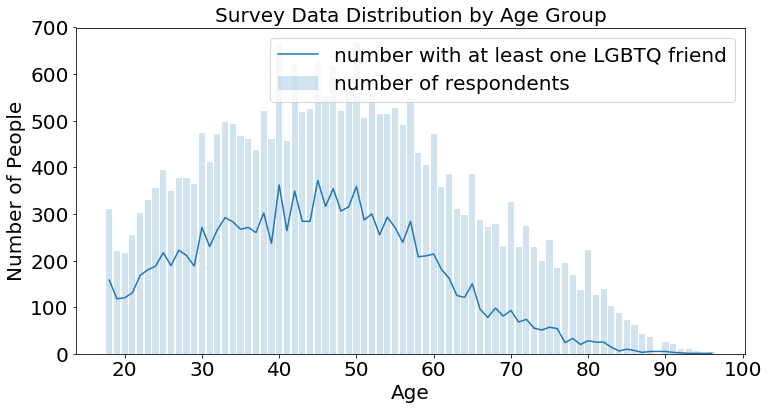

In [30]:
survey.head()
plt.figure(figsize=(12,6))
plt.bar(survey.age,survey.numr, alpha=0.2, label='number of respondents')
plt.plot(survey.age, survey.knowlgbtq, label='number with at least one LGBTQ friend')
plt.title('Survey Data Distribution by Age Group', fontsize=20)
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.legend()

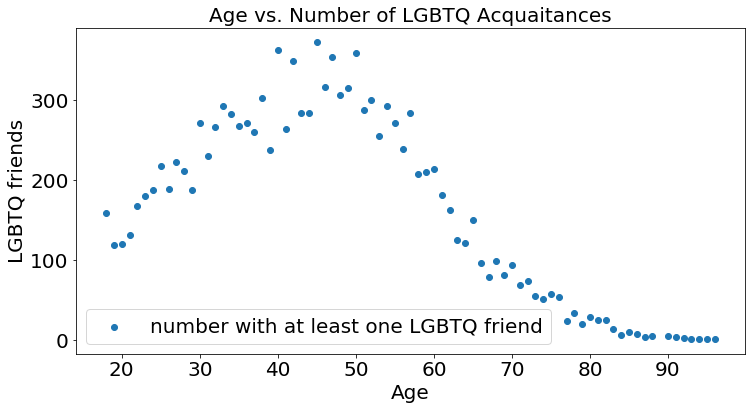

In [31]:
survey.head()
plt.figure(figsize=(12,6))
plt.scatter(survey.age, survey.knowlgbtq, label='number with at least one LGBTQ friend')
plt.title('Age vs. Number of LGBTQ Acquaitances', fontsize=20)
plt.xlabel('Age')
plt.ylabel('LGBTQ friends')
plt.legend()

Text(0, 0.5, 'frequency')

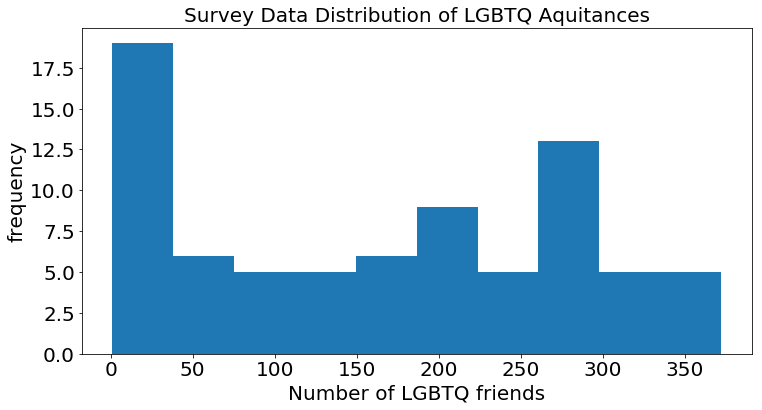

In [32]:
plt.figure(figsize=(12,6))
plt.hist( (survey.knowlgbtq), label='number with at least one LGBTQ friend')
plt.title('Survey Data Distribution of LGBTQ Aquitances', fontsize=20)
plt.xlabel('Number of LGBTQ friends')
plt.ylabel('frequency')

Overall, the data looks reasonable for the most part.  The distribution of responders by age mirrors the distribution of population >18yrs of age.  The number of respondents with at least one LGBTQ acquaitance by age also appears to follow a similar distribution. The overall distribution of # of LGBTQ acquaitances does not appear normal, however (more of a half-Cauchy). We also note that due to very few samples of the oldest population (>90), looking at % of those who have LGBTQ acquaintance can be misleading (i.e the spike in our first chart). We also note, that a regression line would not work for our data. The scatter plot of Age vs. LGBTQ acquaintances points to a polynomial relationship. So I am going to add a polynomial term or two to our Bayesian Regression model. Now that we know what we are working with we will start with Bayesian Regression. 

**2.1**

In [33]:
# a lot of this code is attributed to AM 207 class notes
#run pymc3 on centered data

with pm.Model() as hm2c:
    intercept = pm.Normal('intercept', mu=100, sd=50)
    slope1 = pm.Normal('slope1', mu=0, sd=10)
    slope2=pm.Normal('slope2', mu=0, sd=10)
    slope3=pm.Normal('slope3', mu=0,sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    #I am going to center our data just in case
    mu = pm.Deterministic('mu', intercept + slope1 * (survey.age- survey.age.mean() )+slope2 * (survey.age- survey.age.mean() )**2+slope3 * (survey.age - survey.age.mean())**3)
    knowlgbtq = pm.Normal('knowlgbtq', mu=mu, sd=sigma, observed=survey.knowlgbtq)
    stepper=pm.Metropolis()

#find MAP
try:
    start = vartbl['start']
    tracehm2c = vartbl['tracehm2c']
    print(f'Loaded MAP and samples for hm2c model from {fname}.')
except:
    with hm2c:
        start=pm.find_MAP()
        tracehm2c = pm.sample(20000, stepper,start)
    vartbl['start'] = start
    vartbl['tracehm2c'] = tracehm2c
    save_vartbl(vartbl, fname)


Loaded MAP and samples for hm2c model from gauss_process.pickle.


In [34]:
#remove burnin
trace=tracehm2c[4000::]

Text(0.5, 1.0, 'Trace Plots')

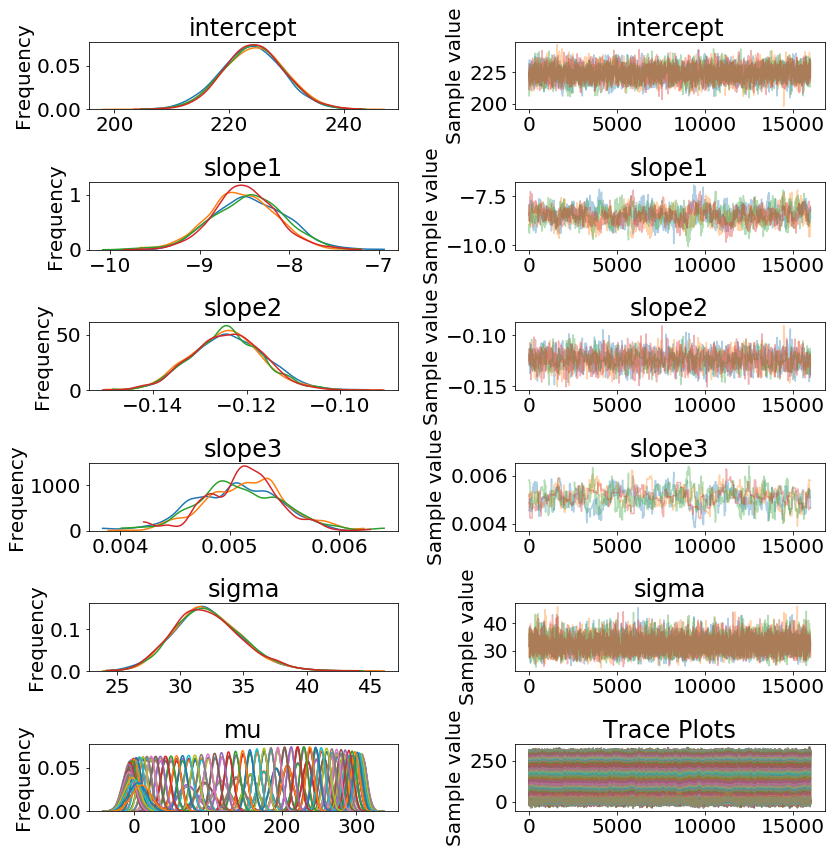

In [35]:
pm.traceplot(trace)
plt.title('Trace Plots')

Text(0.5, 1.0, 'autocorrelation plots')

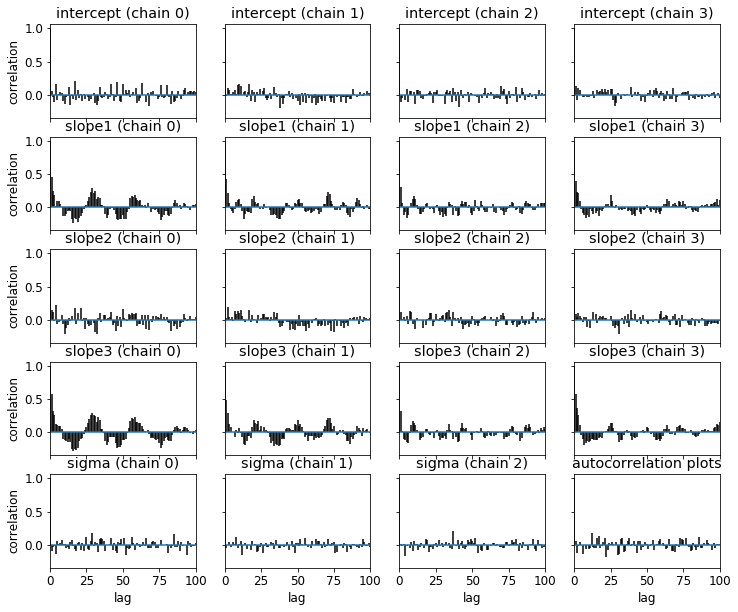

In [36]:
matplotlib.rcParams.update({'font.size': 12})
pm.autocorrplot(trace[::100], varnames=['intercept', 'slope1','slope2','slope3', 'sigma'])
plt.title('autocorrelation plots')

Even after significant thinning, we still see autocorrelation in our model. It is not surprising, however, since we have polynomial version of age that are highly correlated with each other. It would have been better to use orthogonal polynomials/Chebyshev's polynomials here.

Text(0.5, 1.0, 'Posterior Means vs. Survey Data Range')

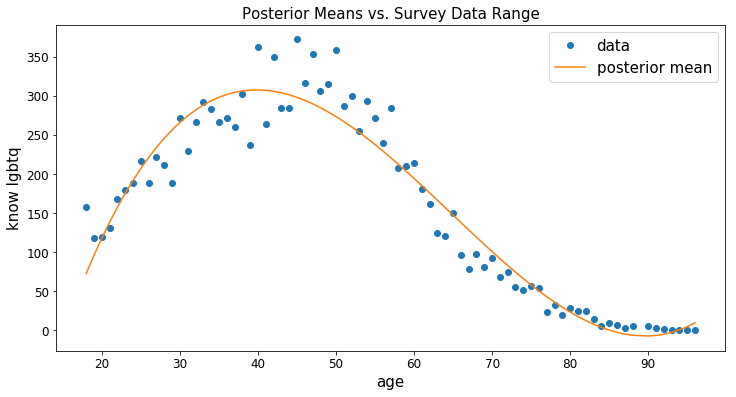

In [37]:
#plot posterior means
plt.figure(figsize=(12,6))
plt.plot(survey.age, survey.knowlgbtq, 'o', label="data")
plt.plot(survey.age, trace[::100]['mu'].mean(axis=0), label="posterior mean")
plt.xlabel("age", fontsize=15)
plt.ylabel("know lgbtq", fontsize=15)
plt.legend(fontsize=15);
plt.title('Posterior Means vs. Survey Data Range', fontsize=15)

In [38]:
#calculate predicted means in the [0,100] range
meanage = survey.age.mean()
agegrid = np.arange(0, 100)
mu_pred = np.zeros((len(agegrid), 4*len(trace)))
for i, a in enumerate(agegrid):
    mu_pred[i] = trace['intercept'] + trace['slope1'] * (a - survey.age.mean())+trace['slope2'] * (a- survey.age.mean())**2+trace['slope3'] * (a - survey.age.mean())**3


In [39]:
#formally define thinned trace
trace=trace[::100]

In [40]:
mu_mean = mu_pred.mean(axis=1)
mu_hpd = pm.hpd(mu_pred.T)

In [41]:
#posterior predictive
postpred = pm.sample_ppc(trace, 1000, hm2c)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1457.39it/s]


In [42]:
postpred['knowlgbtq'].shape

(1000, 78)

Text(0.5, 1.0, 'Post pred means in HPD band and our data with error bars')

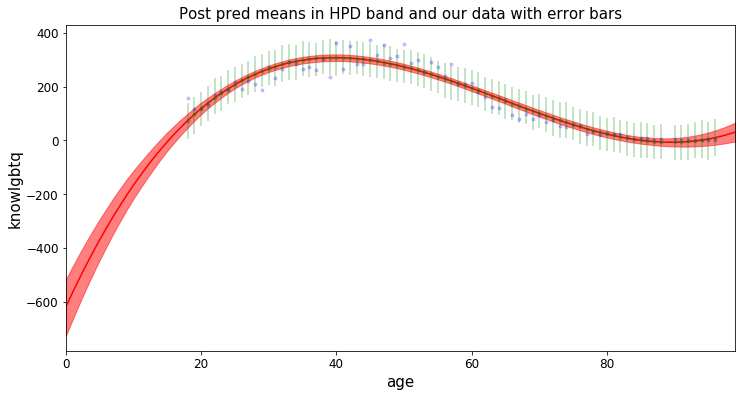

In [43]:
#plot post pred means with HPD and error bars
plt.figure(figsize=(12,6))
postpred_means = postpred['knowlgbtq'].mean(axis=0)
postpred_hpd = pm.hpd(postpred['knowlgbtq'])
plt.plot(survey.age, survey.knowlgbtq, '.', c='b', alpha=0.2)
plt.plot(agegrid, mu_mean, 'r')
plt.fill_between(agegrid, mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.5)
yerr=[postpred_means - postpred_hpd[:,0], postpred_hpd[:,1] - postpred_means] 
plt.errorbar(survey.age, postpred_means, yerr=yerr, fmt='--.', c='g', alpha=0.3, capthick=3)
plt.xlabel('age', fontsize=15)
plt.ylabel('knowlgbtq', fontsize=15)
plt.xlim([agegrid[0], agegrid[-1]]);
plt.title('Post pred means in HPD band and our data with error bars', fontsize=15)



In [44]:
#now lets sample
n_ppredsamps=1000
meanage = survey.age.mean()
ppc_samples=np.zeros((len(agegrid), n_ppredsamps))

for j in range(n_ppredsamps):
    k=np.random.randint(2*len(trace))
    musamps = trace['intercept'][k] + trace['slope1'][k] * (agegrid - survey.age.mean())+trace['slope2'][k] * (agegrid- survey.age.mean())**2+trace['slope3'][k] * (agegrid - survey.age.mean())**3
    sigmasamp = trace['sigma'][k]
    ppc_samples[:,j] = np.random.normal(musamps, sigmasamp)


In [45]:
#Here my assumption is that we are looking for + - 2std interal (i.e. ~95% CI)
ppc_samples_std=[]  
i=0
while i <100:   
    std = 2*np.std((ppc_samples)[i])
    ppc_samples_std.append(std)
    i=i+1

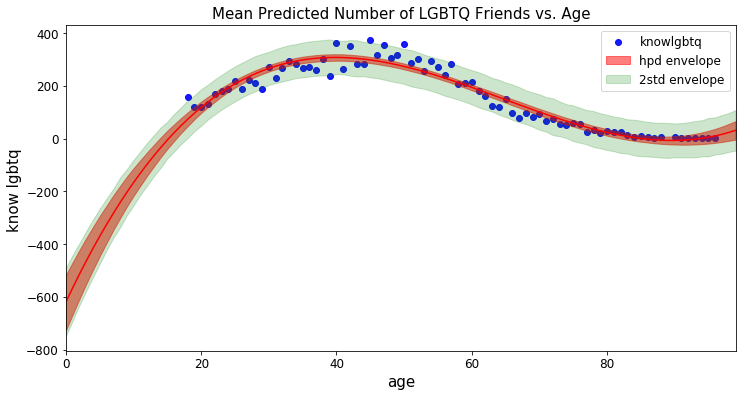

In [46]:
#plot predicted mean with HPD and 95%CI
plt.figure(figsize=(12,6))
plt.scatter(survey.age, survey.knowlgbtq, c='b', alpha=0.9)
plt.plot(agegrid, mu_mean, 'r')
plt.fill_between(agegrid, mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.5, label='hpd envelope')
plt.fill_between(agegrid, mu_mean-ppc_samples_std, mu_mean+ppc_samples_std, color='green', alpha=0.2, label='2std envelope')

plt.title('Mean Predicted Number of LGBTQ Friends vs. Age', fontsize=15)
plt.xlabel('age', fontsize=15)
plt.ylabel('know lgbtq ', fontsize=15)
plt.xlim([agegrid[0], agegrid[-1]])
plt.legend()


Note, we approached this question with polynomial regression. However, we could have also run a simple Bayesian linear regression with 1 linear independent variable.

In [47]:
#if we were to do this analysis more simplistically just on linear feature age we would have the following
with pm.Model() as hm2c_simple:
    intercept = pm.Normal('intercept', mu=100, sd=50)
    slope1 = pm.Normal('slope1', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    #I am going to center our data just in case
    mu = pm.Deterministic('mu', intercept + slope1 * (survey.age- survey.age.mean()) )
    knowlgbtq = pm.Normal('knowlgbtq', mu=mu, sd=sigma, observed=survey.knowlgbtq)
    stepper=pm.Metropolis()

#find MAP
try:
    start_simple = vartbl['start_simple']
    tracehm2c_simple = vartbl['tracehm2c_simple']
    print(f'Loaded MAP and trace for simple model from {fname}.')
except:
    with hm2c_simple:
        start_simple = pm.find_MAP()
        tracehm2c_simple = pm.sample(20000, stepper, start_simple)
    vartbl['start_simple'] = start_simple
    vartbl['tracehm2c_simple'] = tracehm2c_simple
    save_vartbl(vartbl, fname)

Loaded MAP and trace for simple model from gauss_process.pickle.


In [48]:
trace_simple=tracehm2c_simple[4000::]

Text(0.5, 1.0, 'Traceplots for Simple Approach')

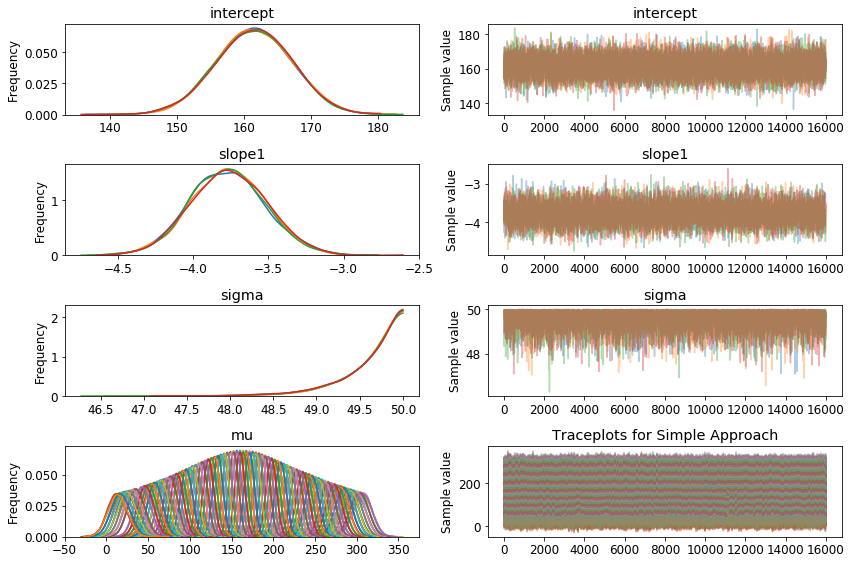

In [49]:
pm.traceplot(trace_simple)
plt.title('Traceplots for Simple Approach')

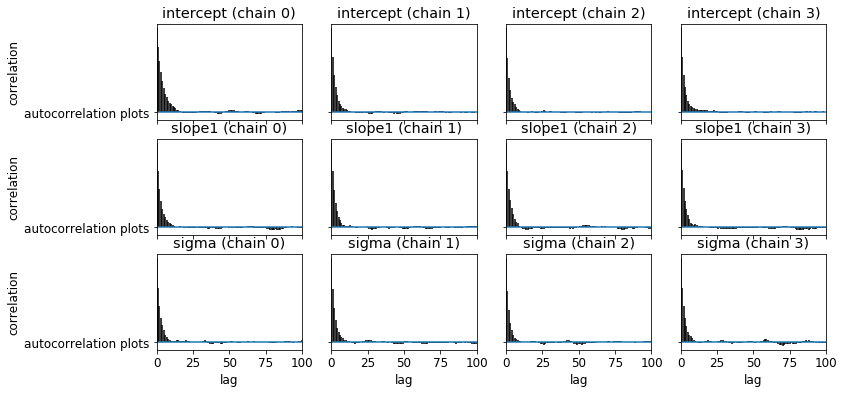

In [50]:
pm.autocorrplot(trace_simple, varnames=['intercept', 'slope1','sigma'])
plt.plot('autocorrelation plots')

Here, not surprisingly we don't see a major autocorrelation problem like we did in the polynomial regression earlier because we are just using one iteration of age variable

Text(0.5, 1.0, 'Posterior Mean vs. Actual Data (simple approach)')

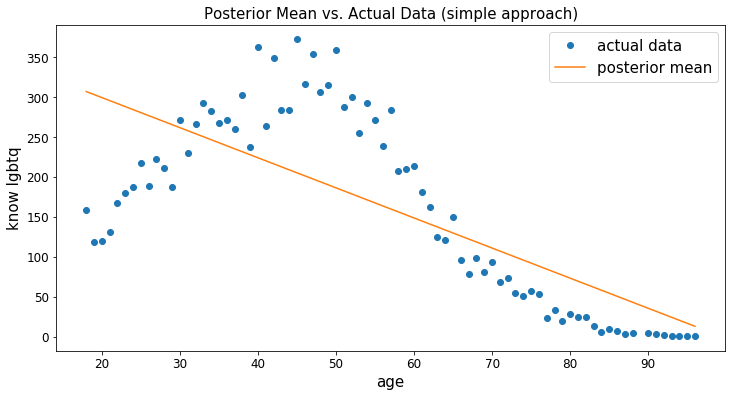

In [51]:
#plot posterior mean
plt.figure(figsize=(12,6))
plt.plot(survey.age, survey.knowlgbtq, 'o', label="actual data")
plt.plot(survey.age, trace_simple['mu'].mean(axis=0), label="posterior mean")
plt.xlabel("age", fontsize=15)
plt.ylabel("know lgbtq", fontsize=15)
plt.legend(fontsize=15);
plt.title('Posterior Mean vs. Actual Data (simple approach)', fontsize=15)

In [52]:
#calculate predicted means in the [0,100] range
meanage = survey.age.mean()
agegrid = np.arange(0, 100)
mu_pred_simple = np.zeros((len(agegrid), 4*len(trace_simple)))
for i, a in enumerate(agegrid):
    mu_pred_simple[i] = trace_simple['intercept'] + trace_simple['slope1'] * (a - survey.age.mean())

In [53]:
mu_mean_simple = mu_pred_simple.mean(axis=1)
mu_hpd_simple = pm.hpd(mu_pred_simple.T)

In [54]:
#posterior predictive
postpred_simple = pm.sample_ppc(trace_simple, 1000, hm2c)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1008.84it/s]


In [55]:
postpred_simple['knowlgbtq'].shape

(1000, 78)

Text(0.5, 1.0, 'Post pred means in HPD band and our data with error bars (simple approach)')

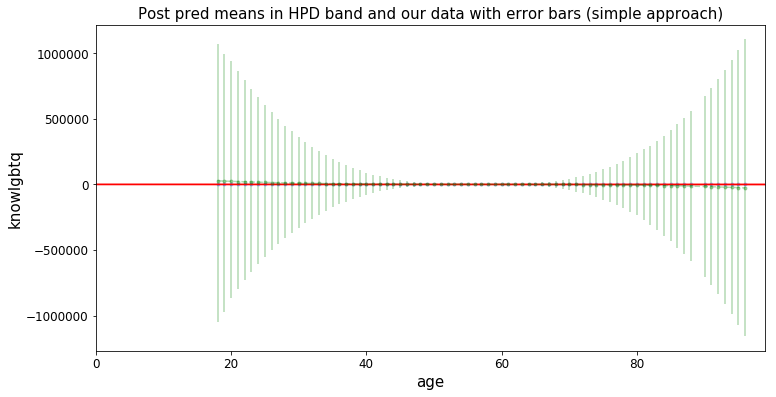

In [56]:
#plotting posterior predictive with HPD and error bars
plt.figure(figsize=(12,6))
postpred_means_simple = postpred_simple['knowlgbtq'].mean(axis=0)
postpred_hpd_simple = pm.hpd(postpred_simple['knowlgbtq'])
plt.plot(survey.age, survey.knowlgbtq, '.', c='b', alpha=0.2)
plt.plot(agegrid, mu_mean_simple, 'r')
plt.fill_between(agegrid, mu_hpd_simple[:,0], mu_hpd_simple[:,1], color='r', alpha=0.5)
yerr_simple=[postpred_means_simple - postpred_hpd_simple[:,0], postpred_hpd_simple[:,1] - postpred_means_simple] 
plt.errorbar(survey.age, postpred_means_simple, yerr=yerr_simple, fmt='--.', c='g', alpha=0.3, capthick=3)
plt.xlabel('age', fontsize=15)
plt.ylabel('knowlgbtq', fontsize=15)
plt.xlim([agegrid[0], agegrid[-1]]);
plt.title('Post pred means in HPD band and our data with error bars (simple approach)', fontsize=15)

In [57]:
#now lets sample
n_ppredsamps=1000
meanage = survey.age.mean()
ppc_samples_simple=np.zeros((len(agegrid), n_ppredsamps))

for j in range(n_ppredsamps):
    k=np.random.randint(2*len(trace))
    musamps_simple = trace_simple['intercept'][k] + trace_simple['slope1'][k] * (agegrid - survey.age.mean())
    sigmasamp_simple = trace_simple['sigma'][k]
    ppc_samples_simple[:,j] = np.random.normal(musamps_simple, sigmasamp_simple)

In [58]:
#calculating st.dev assuming +-2 for ~95% CI
ppc_samples_std_simple=[]  
i=0
while i <100:   
    std = 2*np.std((ppc_samples_simple)[i])
    ppc_samples_std_simple.append(std)
    i=i+1

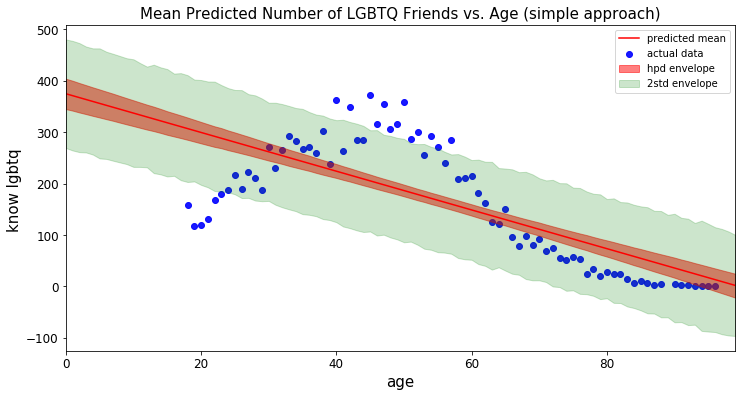

In [59]:
#plot mean with 95% CI and HPD
plt.figure(figsize=(12,6))
plt.scatter(survey.age, survey.knowlgbtq, c='b', alpha=0.9, label='actual data')
plt.plot(agegrid, mu_mean_simple, 'r', label= 'predicted mean')
plt.fill_between(agegrid, mu_hpd_simple[:,0], mu_hpd_simple[:,1], color='r', alpha=0.5, label='hpd envelope')
plt.fill_between(agegrid, mu_mean_simple-ppc_samples_std_simple, mu_mean_simple+ppc_samples_std_simple, color='green', alpha=0.2, label='2std envelope')

plt.title('Mean Predicted Number of LGBTQ Friends vs. Age (simple approach)', fontsize=15)
plt.xlabel('age', fontsize=15)
plt.ylabel('know lgbtq ', fontsize=15)
plt.xlim([agegrid[0], agegrid[-1]])
plt.legend(fontsize=10)

2.2. Using pymc3, create a 1-D Gaussian Process regression model with the same feature and dependent variables.  Use a squared exponential covariance function. Plot the mean predictions for ages 0-100, with a 2-sigma envelope.

(**Hint: For an example of GP Regression from class see [this GP Recap](http://am207.info/wiki/gpsalmon.html)**)

In [60]:
#this code attributed to fonnesbeck and Patrick's office hours
with pm.Model() as gp_model:

    # Lengthscale
    rho = pm.HalfCauchy('rho', beta=10)
    s2_f = pm.HalfCauchy('s2_f', beta=3)
    s2_n = pm.HalfCauchy('s2_n', beta=2)
    
    f_row = (s2_f**2) * pm.gp.cov.ExpQuad(1, rho) 
    mgp=pm.gp.Marginal(cov_func=f_row)
    
    
    y_obs=mgp.marginal_likelihood('knowlgbtq', X=survey.age.values.reshape(-1,1), 
                           y=survey.knowlgbtq.values, noise=s2_n, is_observed=True)    

In [61]:
try:
    lgbtq_trace = vartbl['lgbtq_trace']
    print(f'Loaded trace for lgbtq GP model from {fname}.')
except:
    with gp_model:
        stepper=pm.Metropolis()
        lgbtq_trace = pm.sample(20000,  cores=-1)
    vartbl['lgbtq_trace'] = lgbtq_trace
    save_vartbl(vartbl, fname)

Loaded trace for lgbtq GP model from gauss_process.pickle.


Text(0.5, 1.0, 'trace plots')

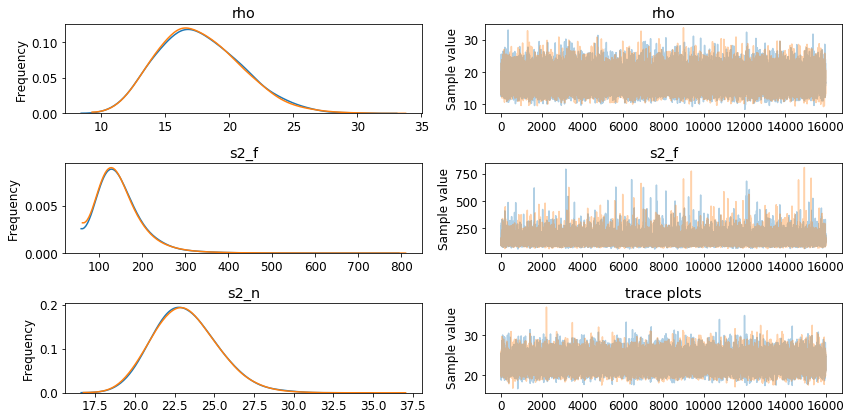

In [62]:
#remove burnin and plot traces
lgbtq_trace = lgbtq_trace[4000:]
pm.traceplot(lgbtq_trace, varnames=['rho', 's2_f', 's2_n'])
plt.title('trace plots')

Text(0.5, 1.0, 'autocorrelation plots')

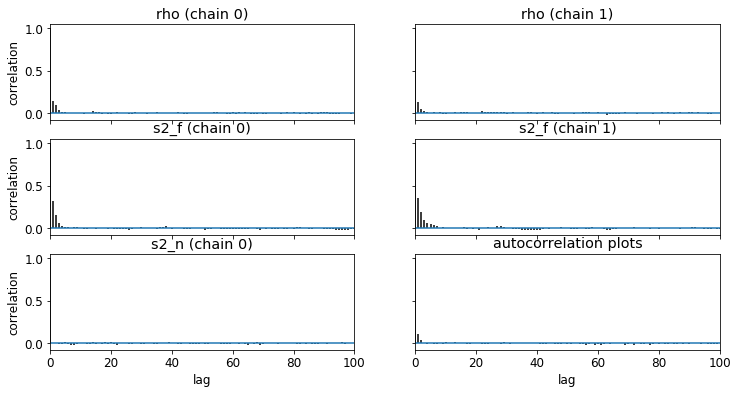

In [63]:
pm.autocorrplot(lgbtq_trace, varnames=['rho', 's2_f','s2_n'])
plt.title('autocorrelation plots')

Note, our autocorrelation plots look a lot better without any thinning than what we saw with Bayesian Regression.

In [64]:
#now lets make predictions and sample
X_pred = np.linspace(0, 100, 100).reshape(-1, 1)
with gp_model:
    lgbtq_pre = mgp.conditional("lgbtq_pre", X_pred)
    lgbtq_samples = pm.sample_ppc(lgbtq_trace, vars=[lgbtq_pre], samples=20)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.80it/s]


In [65]:
means=[]
sds=[]
samps=pd.DataFrame(lgbtq_samples['lgbtq_pre'].T)
i=0
while i < 100:
    sd=2*np.std(np.array(samps.iloc[[i]]))
    sds.append(sd)
    mean=np.mean(np.array(samps.iloc[[i]]))
    means.append(mean)
    i=i+1    

In [66]:
means_neg=np.array(means)-np.array(sds)
means_pos=np.array(means)+np.array(sds)

Text(0, 0.5, 'know LGBTQ')

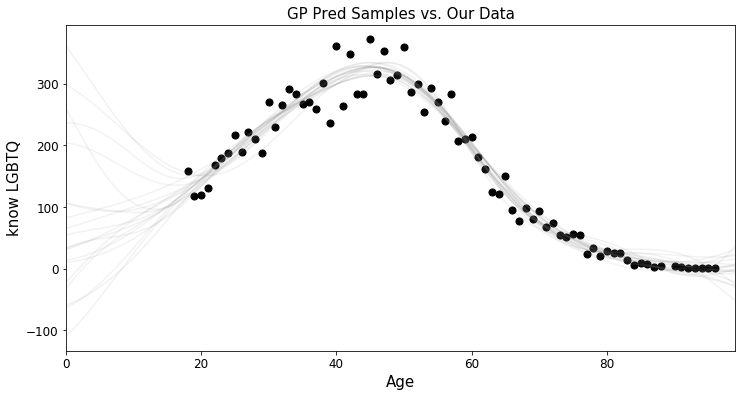

In [67]:
plt.figure(figsize=(12,6))
plt.scatter(survey['age'], survey['knowlgbtq'], c='k', s=50)
plt.xlim([agegrid[0], agegrid[-1]])
for x in lgbtq_samples['lgbtq_pre']:
    plt.plot(X_pred, x, "gray", alpha=0.1)
    
plt.title('GP Pred Samples vs. Our Data', fontsize=15)  
plt.xlabel('Age', fontsize=15)
plt.ylabel('know LGBTQ', fontsize=15)

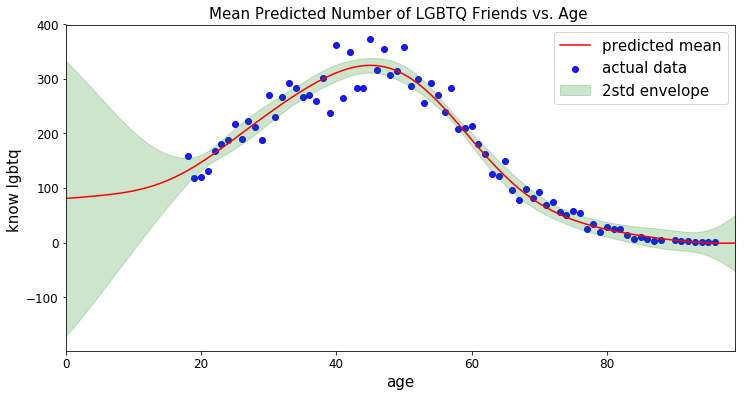

In [68]:
plt.figure(figsize=(12,6))
plt.scatter(survey.age, survey.knowlgbtq, c='b', alpha=0.9, label='actual data')
plt.plot(agegrid, means, 'r', label='predicted mean')
plt.fill_between(agegrid, means_neg, means_pos, color='green', alpha=0.2, label='2std envelope')

plt.title('Mean Predicted Number of LGBTQ Friends vs. Age ', fontsize=15)
plt.xlabel('age', fontsize=15)
plt.ylabel('know lgbtq ', fontsize=15)
plt.xlim([agegrid[0], agegrid[-1]])
plt.legend(fontsize=15)

**2.3.** How do the models compare? Does age influence likelihood of acquaintance with someone LGBTQ? For Bayesian Linear Regression and GP Regression, how does age affect the variance of the estimates?


When we look at the two models (both simple and polynomial Bayesian and our GP model above), we notice that the GP model outperforms the Bayesian model when it comes to both fitting to our existing data and making predictions in the age range where we dont' have any data.  Note that our simple Bayesian regression model missed the curve entirely, plotting a straight line that fit our curving data very poorly and forecasted unreastic values (i.e. 300-500 babies at age 0 have at least one LGBTQ acquientance).  While our polynomial Bayesian regression did a better job fitting the curvature of our data than the simple regression model, it too made highly unrealistic forecasts for the data points where we had no data. In this case, Bayesian polynomial regression forecasts negative 500-800 babies who are friends with at least one LGBTQ person.  Although, the polynomial model did better for folks at age 100 predicting what looks like a realistic,low, positive value.  Simple Bayesian regression, on the other hand, included negative values in its 95% CI.  

When we look at the GP model above, we note that the it predicts more reasonable mean values at the tails where we have no data (i.e. positive, small values, consistent with the curvature of our data). In addition, we note a much more robust trace and autocorrelation plots for the GP model than either of the Bayesian regression models (which might explain why we get more reasonable estimates with GP). 

In addition, while with Bayesian regression, we did not see fanning out of the 95% CI at the tails (it remained fairly consistent throughout for both simple and polynomial models), we see a different picture with GP model above. The 95% CI fans out sharply at the tails where we have no values, indicating high uncertainty, and narrows sharply where we have observations, indicating higher confidence in its forecasts. In other words, we see more variance in estimates at low and high age for GP model than for Bayesian model (surprising as I would expect to see high variance at the tails for both). To be fair, when we plotted HPD (Highest Posterior density interval) it does fan out at the tails juts like standard deviation for the GP model (albeit less varried in its width than GPD st.dev envelope).

Finally, looking at our models we note that there appears to be a positive relationship between age and number of LGBTQ acquientances in the 0-50 age group. However, this trend turns negative in the 50-100 age group.  One could infer that young adults through middle aged adults tend to know/meet more LGBTQ folks than adults 60years of age and older. If we only built a simple linear Bayesian regression, we would have made the wrong/oversimplified conclusion that the number of LGBTQ friends goes down with age.  However, it appears that we have two important/opposing trends here. Of course, the model is not adjusted for population size in each group and in the future, I would have preferred to model per capital LGBTQ friends for each age group.

**Gratuitous Titular References**:  

Massachusett's own [Joiner Lucas](https://en.wikipedia.org/wiki/Joyner_Lucas) blew up in November 2017 with the release of his single ["I'm Not Racist"](https://www.youtube.com/watch?v=43gm3CJePn0) on Youtube.  The video quickly went viral. The title comes from the song's lyrics (and references that degrees of separation that can be involved in individual experience with members of any under-represented group).

Given the oncoming cold spell [Winter Blues](https://www.youtube.com/watch?v=I7_ofdl9Wfs) another popular track may be relevant.

<div class="answer-separator">
------------------------
</div>

## Question 3 - AM207 HWs Out (A OK I MIC DROP)!

**coding required**

In the dataset [reviews_processed.csv](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjoyzcmjk5tv8%2Freviews_processed.csv), you'll find a database of Yelp reviews for a number of restaurants. These reviews have already been processed and transformed by someone who has completed the (pre) modeling process described in HW 10 Question 1. That is, imagine the dataset in "reviews_processed.csv" is the result of feeding the raw Yelp reviews through the pipeline someone built for that question.

The following is a full list of columns in the dataset and their meanings:

I. Relevant to 3.1-3.5:

  1. "review_id" - the unique identifier for each Yelp review
  2. "topic" - the subject addressed by the review (0 stands for food and 1 stands for service)
  3. "rid" - the unique identifier for each restaurant
  4. "count" - the number of sentences in a particular review on a particular topic
  5. "mean" - the probability of a sentence in a particular review on a particular topic being positive, averaged over total number of sentences in the review related to that topic.
  6. "var" - the variance of the probability of a sentence in a particular review on a particular topic being positive, taken over all sentences in the review related to that topic.

II. Relevant (possibly) to more complex models:

  1. "uavg" - the average star rating given by a particular reviewer (taken across all their reviews)
  2. "stars" - the number of stars given in a particular review
  3. "max" - the max probability of a sentence in a particular review on a particular topic being positive
  4. "min" - the min probability of a sentence in a particular review on a particular topic being positive

The following schema illustrates the model of the raw data that is used to generate "reviews_processed.csv":
<img src="https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjoz064i9yaxb%2Frestuarant_model.png" width=500/>

***Warning:*** *this is a "real" data science problem in the sense that the dataset in "reviews_processed.csv" is large. We understand that a number of you have limited computing resources, so you are encouraged but not required to use the entire dataset. If you wish you may use 10 restaurants from the dataset, as long as your choice of 10 contains a couple of restaurants with a large number of reviews and a couple with a small number of reviews.*


When the value in "count" is low, the "mean" value can be very skewed.

3.1. Following the [SAT prep school example discussed in lab](https://am207.info/wiki/gelmanschoolstheory.html) (and influenced your answers for HW 10 Question #1), set up a Bayesian model (that is, write functions encapsulating the pymc3 code) for a reviewer $j$'s opinion of restaurant $k$'s food and service (considering the food and service separately).  You should have a model for each restaurant and each aspect being reviewed (food and serivce). For restaurant $k$, you will have a model for $\{\theta_{jk}^{\text{food}}\}$ and one for $\{\theta_{jk}^{\text{service}}\}$, where $\theta_{jk}$ is the positivity of the opinion of the $j$-th reviewer regarding the $k$-th restaurant. 

**Hint:** What quantity in our data naturally corresponds to $\bar{y}_j$'s in the prep school example? How would you calculate the parameter $\sigma_j^2$ in the distribution of $\bar{y}_j$ (note that, contrary to the school example, $\sigma_j^2$ is not provided explictly in the restaurant data)?

3.2. Just to test your that modeling makes sense choose 1 restaurant and run your model from 3.1 on the food and service aspects for that restaurant.  Create 10K samples  each for the food and service model for your chosen restuarant and visualize your samples via a traceplot for each aspect of the restaurant reviews.

3.3. Use your model from 3.1 to produce estimates for $\theta_{jk}$'s for multiple restaurants. Pick a few (try for 5 but if computer power is a problem, choose 2) restaurants and for each aspect ("food" and "service") of each restaurant, plot your estimates for the $\theta$'s against the values in the "mean" column (corresponding to this restaurant). 

For the chosen restaurants, for each aspect ("food" and "service"), generate shrinkage plots and probability shrinkage plots as follows:

**Shrinkage plot for a restaurant, topic**:

> The aim for this plot is to see the shrinkage from sample means (error bars generated from standard error) to $\theta_{jk}$'s (error bars generated from theta variance).  
>
> The sample means of reviews are plotted at $y=0$ and the posterior means ($\theta_{ik}$) are plotted at $y=1$. For each review connect the sample mean to the posterior mean with a line.  Show error bars on the sample mean points using standard error and on the ($\theta_{jk}$) points using variance.

**Probability Shrinkage plot for a restaurant, topic**:

> The aim for this plot is to see the shrinkage from the classification probabilities from the sample means of reviews to the classification probabilities of $\theta_{jk}$'s.  The classification probabilities are calculated from the gaussian at the given mean and variance. The sample means and standard error are fed into the gaussian to generate one set of classification probabilities.  The $\theta_{jk}$ estimates and variances are fed into the gaussian to generate the other set of variances.
>
> The y values are the classification probability (calculated as 1-cdf) using the normal distribution at a given mean and variance.
>
> The sample means of reviews are plotted with $y$'s obtained by using the sample means as the means in the normal above, with line segments (error bars) representing the standard error. 
>
> The posterior means ($\theta_{jk}$) are plotted with $y$'s obtained using the posterior means (thetas) in the gaussian above, and variances on the thetas with line segments (error bars) representing the variances on the $\theta_{jk}$'s.
>
>We've provided you some code to generate a shrinkage plot and a probability shrinkage plot is included in this notebook, but feel free to implement your own. The code should also help elucidate the text above.

Example of a shrinkage plot:
<img src="https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjop9gx9xfww9%2Fshrinkage.png" width="400" height="400"/>

Example of a probability shrinkage plot:
<img src="https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjop9fsbbu9bs%2Fshrinkage_prob.png" width="400" height="400"/>


3.4. Based on your shrinkage plots and probability shrinkage plots in 3.3 discuss the statistical benefits of modeling each reviewer's opinion using your hierarchical model rather than approximating the reviewer opinion with the value in "mean".

3.5. Aggregate, in a simple but reasonable way, the reviewer's opinions given a pair of overall scores for each restaurant -- one for food and one for service. Rank the restaurants by food score and then by service score. 

(**Hint:**  Think what an average score for each aspect would do here?)

3.6. Discuss the statistical weakness of ranking by these scores.

(**Hint:** What is statistically problematic about the way you aggregated the reviews of each restaurant to produce an overall food or service score? This is also the same problem with summarizing a reviewer's opinion on a restaurants service and food based on what they write.)  

In [69]:
# Load persisted table of variables
fname: str = 'restaurant_reviews.pickle'
vartbl: Dict = load_vartbl(fname)

# Set small font size for plots
matplotlib.rcParams.update({'font.size': 12})

In [70]:
import itertools
from scipy.special import erf
# Use 1-cdf at 0.5 to model the probability of having positive sentiment
# it basically tells you the area under the gaussian after 0.5 (we'll assume 
# positive sentiment based on the usual probability > 0.5 criterion)

prob = lambda mu, vari: .5 * (1 - erf((0.5- mu) / np.sqrt(2 * vari)))

# fix a restaurant and an aspect (food or service)
# "means" is the array of values in the "mean" column for the restaurant and the aspect 
#         in the dataset
# "thetas" is the array of values representing your estimate of the opinions of reviewers 
#          regarding this aspect of this particular restaurant
# "theta_vars" is the array of values of the varaiances of the thetas
# "counts" is the array of values in the "count" column for the restaurant and the aspect 
#.         in the dataset
# FEEL FREE TO RE-IMPLEMENT THESE

def shrinkage_plot(means, thetas, mean_vars, theta_vars, counts, ax):
    """
    a plot that shows how review means (plotted at y=0) shrink to
    review $theta$s, plotted at y=1
    """
    data = zip(means, thetas, mean_vars / counts, theta_vars, counts)   
    palette = itertools.cycle(sns.color_palette())
    with sns.axes_style('white'):
        for m,t, me, te, c in data: # mean, theta, mean errir, thetax error, count
            color=next(palette)
            # add some jitter to y values to separate them
            noise=0.04*np.random.randn()
            noise2=0.04*np.random.randn()
            if me==0:
                me = 4
            # plot shrinkage line from mean, 0 to
            # theta, 1. Also plot error bars
            ax.plot([m,t],[noise,1+noise2],'o-', color=color, lw=1)
            ax.errorbar([m,t],[noise,1+noise2], xerr=[np.sqrt(me), np.sqrt(te)], color=color,  lw=1)
        ax.set_yticks([])
        ax.set_xlim([0,1])
        sns.despine(offset=-2, trim=True, left=True)
    return plt.gca()

def prob_shrinkage_plot(means, thetas, mean_vars, theta_vars, counts, ax):
    """
    a plot that shows how review means (plotted at y=prob(mean)) shrink to
    review $theta$s, plotted at y=prob(theta)
    """
    data = zip(means, thetas, mean_vars / counts, theta_vars, counts)
    palette = itertools.cycle(sns.color_palette())
    with sns.axes_style('white'):
        for m,t, me, te, c in data: # mean, theta, mean errir, theta error, count
            color = next(palette)
            # add some jitter to y values to separate them
            noise = 0.001 * np.random.randn()
            noise2 = 0.001 * np.random.randn()
            if me == 0: #make mean error super large if estimated as 0 due to count=1
                me = 4
            p = prob(m, me)
            peb = prob(t, te)
            # plot shrinkage line from mean, prob-based_on-mean to
            # theta, prob-based_on-theta. Also plot error bars
            ax.plot([m, t],[p, peb],'o-', color=color, lw=1)
            ax.errorbar([m, t],[p + noise, peb + noise2], xerr=[np.sqrt(me), np.sqrt(te)], color=color, lw=1)
        ax = plt.gca()
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1.05])
    return ax

**3.1** Following the SAT prep school example discussed in lab, set up a Bayesian model (that is, write functions encapsulating the pymc3 code) for a reviewer  j 's opinion of restaurant  k 's food and service (considering the food and service separately). 

In [71]:
# Load the review data    
reviews_df = pd.read_csv('reviews_processed.csv')

def get_rest_topic_model(reviews_df, topic, rid):
    """Return a model describing the given topic and restaurant with the restaurant ID = rid."""
    rest_topic = reviews_df.loc[(reviews_df.rid == rid) & (reviews_df['count'] > 1) & (reviews_df.topic == topic)]
    j_obs = rest_topic.shape[0]
    y_obs = rest_topic['mean'].values
    sigma_obs = np.sqrt(rest_topic['var'].values / rest_topic['count'].values)
    
    with pm.Model() as model:
        mu = pm.Normal('mu', mu=.5, sd=.15)
        tau = pm.HalfCauchy('tau', beta=.1)
        nu = pm.Normal('nu', mu=0, sd=.5, shape=j_obs)
        theta = pm.Deterministic('theta', mu + tau*nu)
        obs = pm.Normal('obs', mu=theta, sd=sigma_obs, observed=y_obs)
        
    return model


def get_rest_model(data, rid):
    """
    Return a tuple of two models describing the food (topic=0) and service (topic=1) 
    of the restuarant with restaurant id = rid."""
    return get_rest_topic_model(data, 0, rid), get_rest_topic_model(data, 1, rid)

**3.2** Just to test your that modeling makes sense choose 1 restaurant and run your model from 3.1 on the food and service aspects for that restaurant. Create 10K samples each for the food and service model for your chosen restuarant and visualize your samples via a traceplot for each aspect of the restaurant reviews.

In [72]:
# Get the restaurant ID for the review in slot 6 in reviews_df
rid = reviews_df.rid[6]
# Get the models for food and service on this restaurant
food_model, service_model = get_rest_model(reviews_df, rid)

# Draw 10,000 samples from the food model
try:
    food_trace = vartbl['food_trace']
    print(f'Loaded food_trace from {fname}.')
except:
    with food_model:
        # Need to manually specify cores=1 to avoid broken pipes bug on Windows platform
        food_trace = pm.sample(draws=10000, init=None, tune=1000, cores=1)
    vartbl['food_trace'] = food_trace
    save_vartbl(vartbl, fname)

# Draw 10,000 samples from the service model
try:
    service_trace = vartbl['service_trace']
    print(f'Loaded service_trace from {fname}.')
except:
    with service_model:
        # Need to manually specify cores=1 to avoid broken pipes bug on Windows platform
        service_trace = pm.sample(draws=10000, init=None, tune=1000, cores=1)
    vartbl['service_trace'] = service_trace
    save_vartbl(vartbl, fname)

Loaded food_trace from restaurant_reviews.pickle.
Loaded service_trace from restaurant_reviews.pickle.


Food:


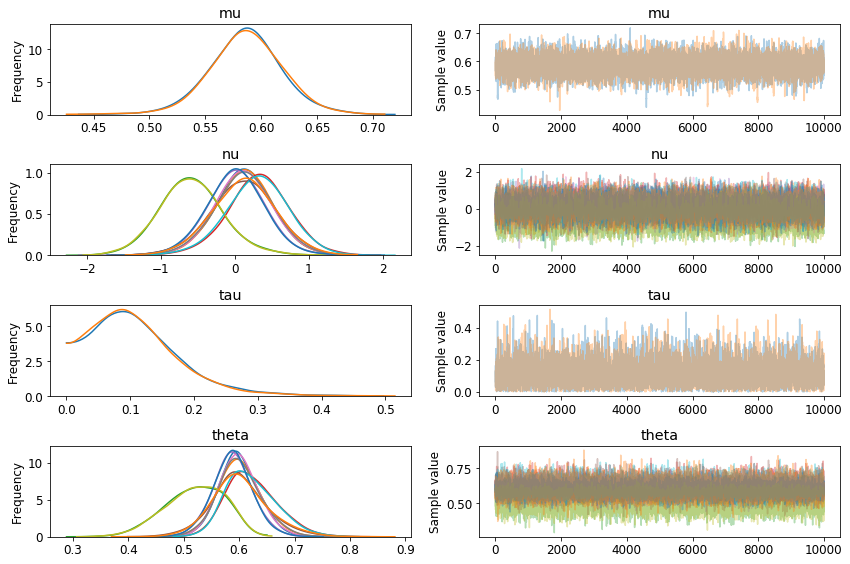

In [73]:
# Display the traceplot for food reviews on this restaurant
print('Food:')
pm.traceplot(food_trace)
plt.show()

Service:


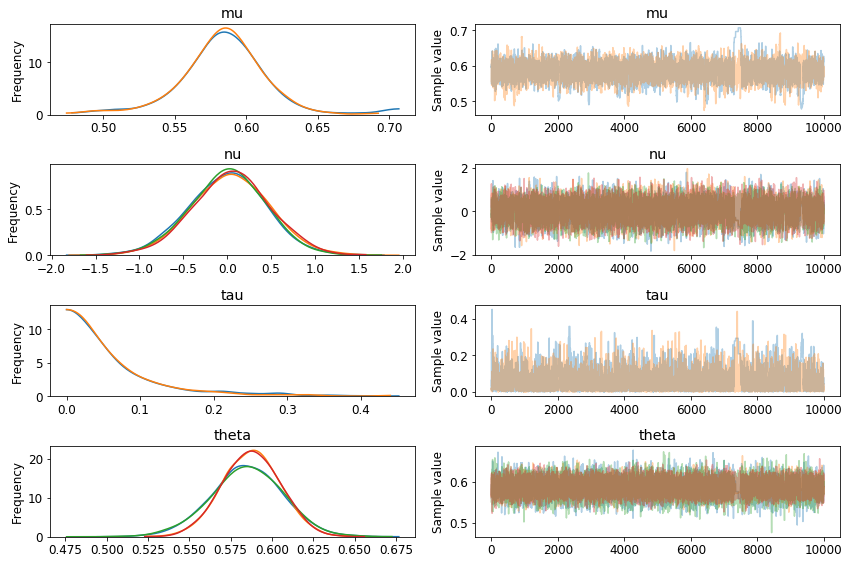

In [74]:
# Display the traceplot for food reviews on this restaurant
print('Service:')
pm.traceplot(service_trace)
plt.show()

**3.3** Use your model from 3.1 to produce estimates for  θjk 's for multiple restaurants. Pick a few (try for 5 but if computer power is a problem, choose 2) restaurants and for each aspect ("food" and "service") of each restaurant, plot your estimates for the  θ 's against the values in the "mean" column (corresponding to this restaurant).

In [75]:
def get_ths(trace):
    """Get the mean theta for each restaurant"""
    return trace['theta'].mean(axis=0).tolist()


def get_th_vars(trace):
    """Get the variance of theta for each restaurant"""
    return trace['theta'].var(axis=0).tolist()

# Build an array with all the distinct restaurants that are reviewed
all_rids = np.array(list(set(reviews_df.rid)))
# Generate a sample with 5 of them
rests = all_rids[[5,6,7,8,9]].tolist()
rest_count = len(rests)

# Build models for each restaurant (on both food and service)
models = [get_rest_model(reviews_df, rid) for rid in rests]

# Sample traces for the food and service models of each retaurant
try:
    traces = vartbl['traces']
    print(f'Loaded traces for {rest_count} restaurants from {fname}.')
except:
    traces = []
    for food_mod, service_mod in models:
        with food_mod:
            food_trace = pm.sample(draws=10000, init=None, tune=1000, cores=1)
        with service_mod:
            service_trace = pm.sample(draws=10000, init=None, tune=1000, cores=1)
        traces.append((food_trace, service_trace))
    vartbl['traces'] = traces
    save_vartbl(vartbl, fname)

Loaded traces for 5 restaurants from restaurant_reviews.pickle.


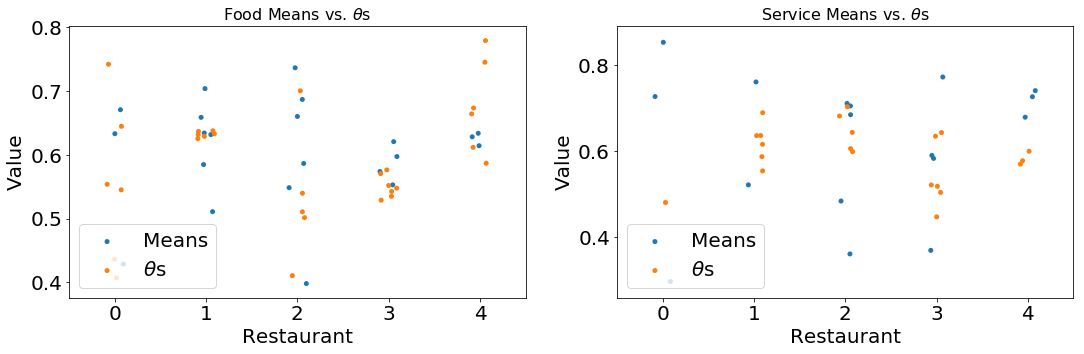

In [76]:
# Compute the mean for the food and service reviews for each restaurant sampled
means_food, means_service = [], []
for rid in rests:
    food_idx = (reviews_df.rid == rid) & (reviews_df['count'] > 1) & (reviews_df.topic == 0)
    means_food.append(reviews_df.loc[food_idx]['mean'].values)
    service_idx = (reviews_df.rid == rid) & (reviews_df['count'] > 1) & (reviews_df.topic == 1)
    means_service.append(reviews_df.loc[service_idx]['mean'].values)

# Extract the estimated thetas for each resturant
ths_food, ths_service = [], []
for food_trace, service_trace in traces:
    ths_food.append(get_ths(food_trace))
    ths_service.append(get_ths(service_trace))

# Plot the food and service means for each restaurant
matplotlib.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(ncols=2, figsize=(18, 5))
sns.stripplot(data=means_food, color=sns.color_palette()[0], ax=axes[0], label='Means')
sns.stripplot(data=ths_food, color=sns.color_palette()[1], ax=axes[0], label=r'$\theta$s')
sns.stripplot(data=means_service, color=sns.color_palette()[0], ax=axes[1], label='Means')
sns.stripplot(data=ths_service, color=sns.color_palette()[1], ax=axes[1], label=r'$\theta$s')
axes[0].set_title(r'Food Means vs. $\theta$s', fontsize=16)
axes[1].set_title(r'Service Means vs. $\theta$s', fontsize=16)
for ax in axes:
    ax.set_xlabel('Restaurant')
    ax.set_ylabel('Value')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[0], handles[-1]], [labels[0], labels[-1]], loc='lower left')
plt.show()

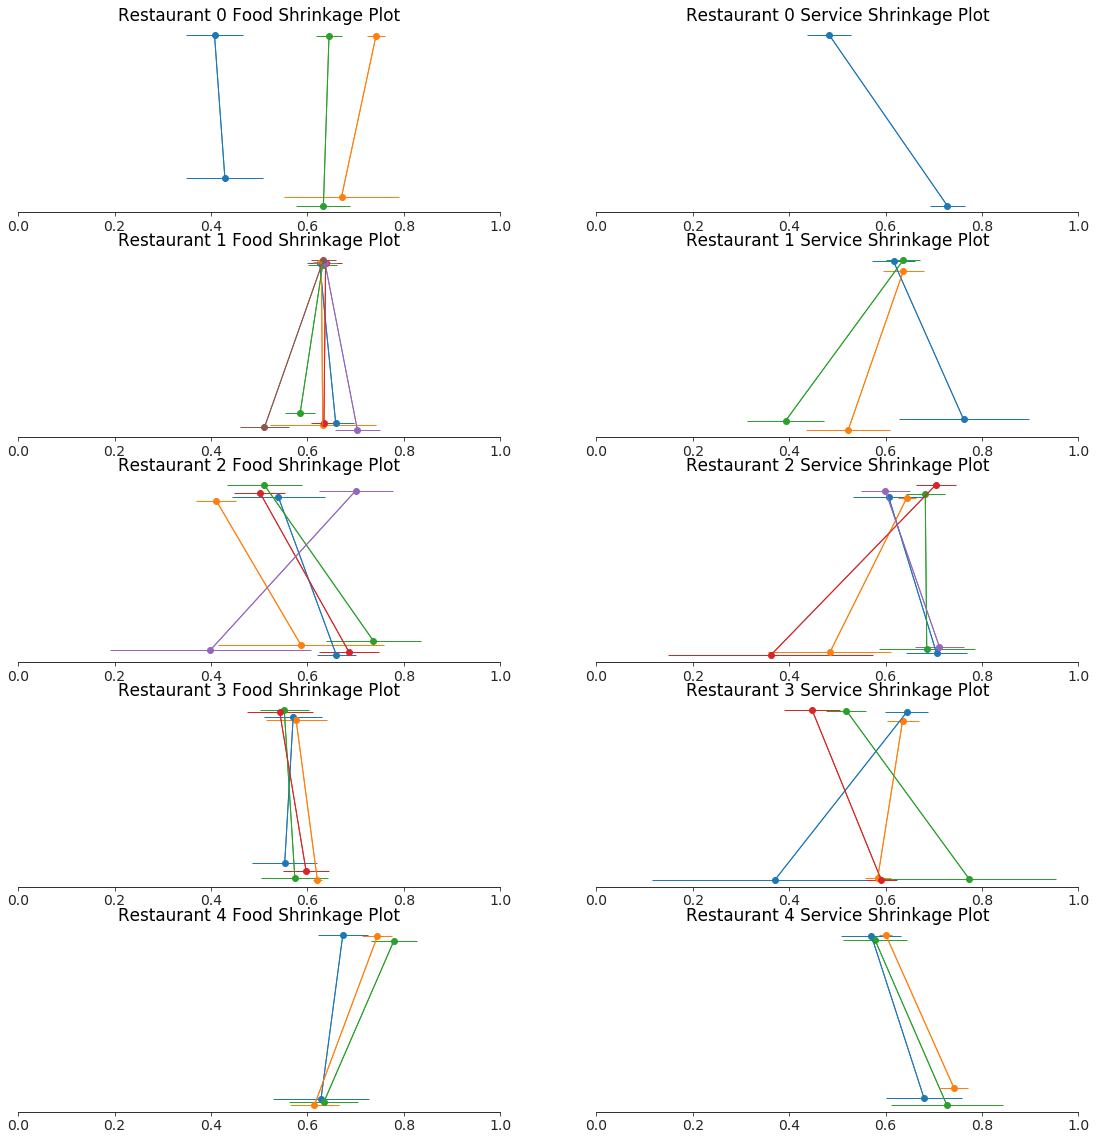

In [77]:
# Compute the variance for the food and service reviews for each restaurant 
# (this is a variance over the actual data)
mean_vars_food, mean_vars_service = [], []
for rid in rests:
    food_idx = (reviews_df.rid == rid) & (reviews_df['count'] > 1) & (reviews_df.topic == 0)
    mean_vars_food.append(reviews_df.loc[food_idx]['var'].values)
    service_idx = (reviews_df.rid == rid) & (reviews_df['count'] > 1) & (reviews_df.topic == 1)
    mean_vars_service.append(reviews_df.loc[service_idx]['var'].values)

# Count the number of food and service reviews for each restaurant sampled
counts_food, counts_service = [], []
for rid in rests:
    food_idx = (reviews_df.rid == rid) & (reviews_df['count'] > 1) & (reviews_df.topic == 0)
    counts_food.append(reviews_df.loc[food_idx]['count'].values)
    service_idx = (reviews_df.rid == rid) & (reviews_df['count'] > 1) & (reviews_df.topic == 1)
    counts_service.append(reviews_df.loc[service_idx]['count'].values)

# Extract the estimated variance of the thetas for each each restaurant
# (this is a variance over sampled paramaters data)
th_vars_food, th_vars_service = [], []
for food_trace, service_trace in traces:
    th_vars_food.append(get_th_vars(food_trace))
    th_vars_service.append(get_th_vars(service_trace))

# Generate the shrinkage plots for food and service
matplotlib.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(19, 20))
for iax, ax in enumerate(axes.ravel()):
    topic = iax % 2
    r = iax // 2
    if topic:
        shrinkage_plot(means_service[r], ths_service[r], mean_vars_service[r], th_vars_service[r], counts_service[r], ax)
        ax.set_title(f'Restaurant {r} Service Shrinkage Plot')
    else:
        shrinkage_plot(means_food[r], ths_food[r], mean_vars_food[r], th_vars_food[r], counts_food[r], ax)
        ax.set_title(f'Restaurant {r} Food Shrinkage Plot')

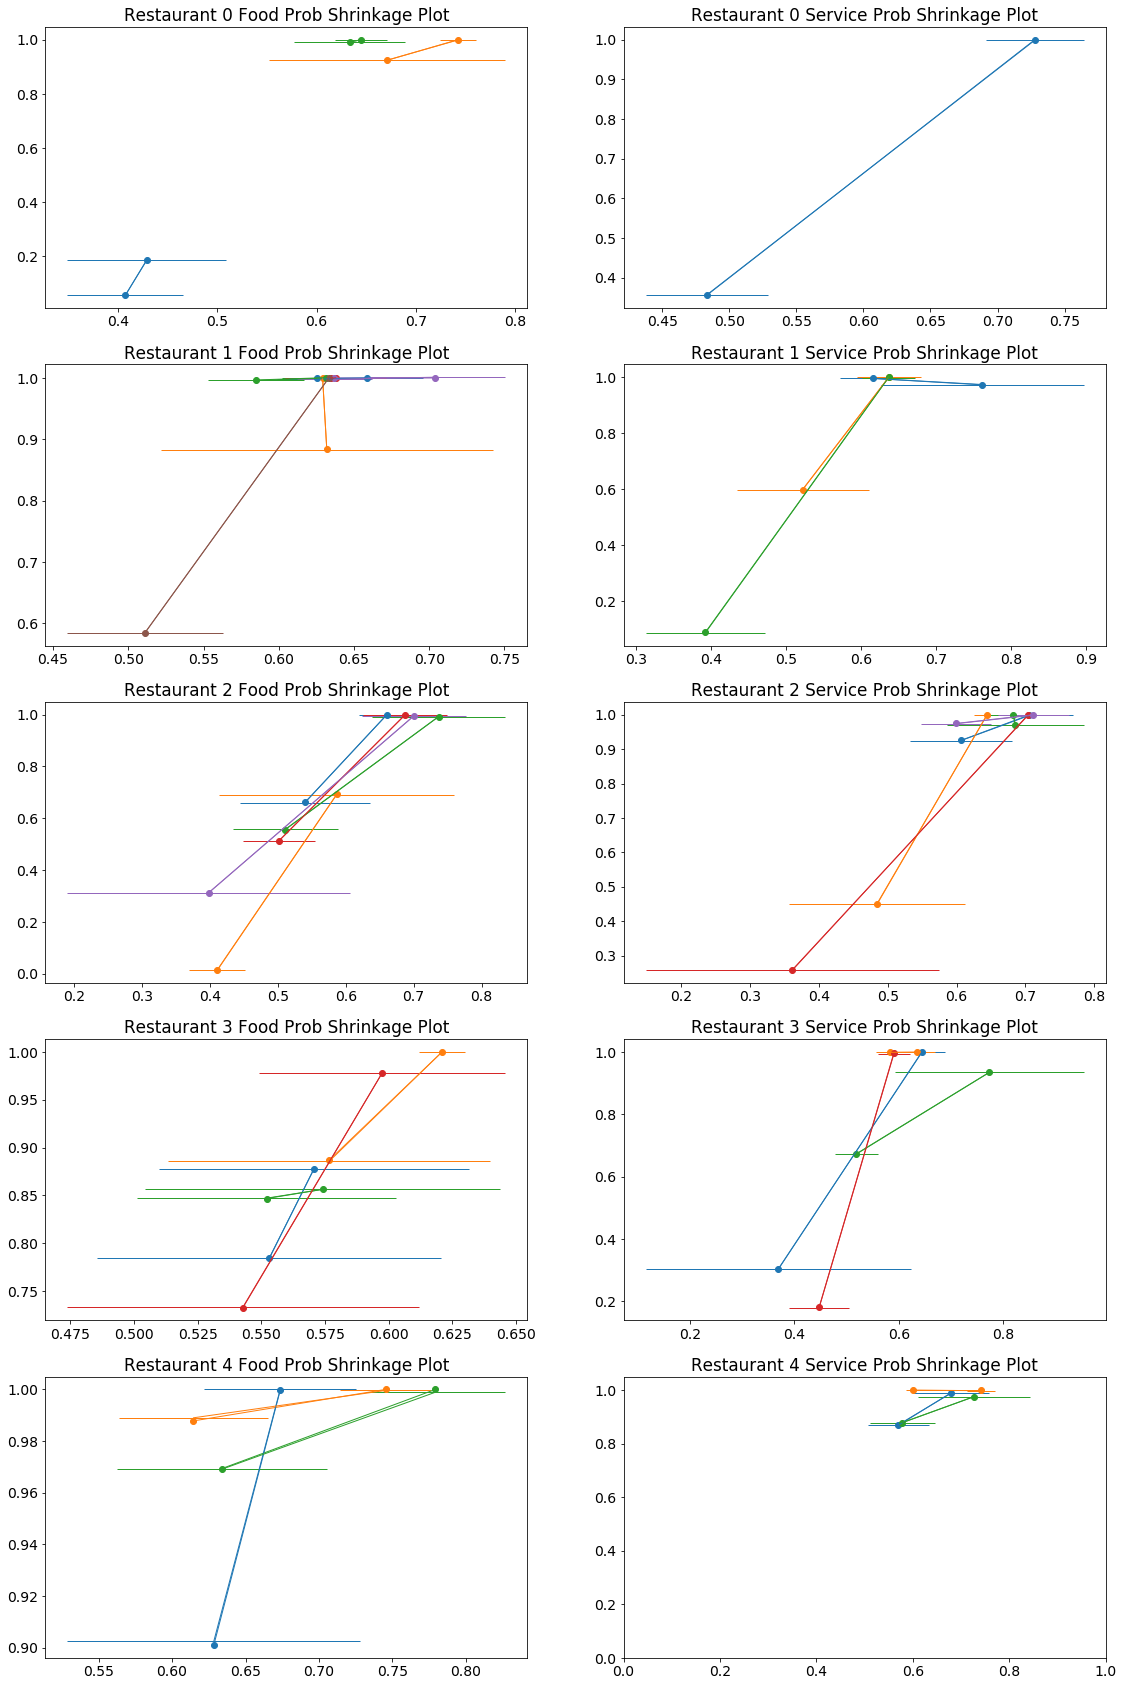

In [78]:
# Generate the probability shrinkage plots for food and service
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(19, 30))
for iax, ax in enumerate(axes.ravel()):
    topic = iax % 2
    r = iax // 2
    if topic:
        prob_shrinkage_plot(means_service[r], ths_service[r], mean_vars_service[r], th_vars_service[r], counts_service[r], ax)
        ax.set_title(f'Restaurant {r} Service Prob Shrinkage Plot')
    else:
        prob_shrinkage_plot(means_food[r], ths_food[r], mean_vars_food[r], th_vars_food[r], counts_food[r], ax)
        ax.set_title(f'Restaurant {r} Food Prob Shrinkage Plot')

**3.4** Based on your shrinkage plots and probability shrinkage plots in 3.3 discuss the statistical benefits of modeling each reviewer's opinion using your hierarchical model rather than approximating the reviewer opinion with the value in "mean".

I will start by saying in my own words what the shrinkage plot is showing.  On the bottom (y=0) we can see the sample mean in the center and an error bar around it.  This is giving us an estimate of the overall impression that reviewers have of the food or service at a given restaurant.  At the top (y=1) we have the posterior mean and variance after we have performed Bayesian inference.  The first sign that the Bayesian inference is helping compared to a simplistic sample mean is that the width of the error bars are quite a bit smaller.  This is the "shrinkage" in the name shrinkage plot, and it is allowing us to visualize how much we have reduced the uncertainty in our estimates by Bayesian inference.  In this case, we can see that for most of the restaurants, we are able to generate a tighter band in the posterior than by using the simple sample means.  In particular, there are far fewer restaurants with very wide bands.

An intuitive explanation for this is that the simplistic model using sample means is vulnerable to sampling errors especially on restaurants with a small number of reviews on a topic (e.g. a restaurant where only 1 or 2 reviews mention the service).  The posterior model incorporates powerful information about the overall reviews people tend to give to restaurants about their food and service.  Most restauarants are pretty good, or they would close down.  They are probably rated around 3.8 to 4.2 stars.  If a single person gave a restaurant a poor service review, estimating its service quality at 0 stars is much worse than performing a small Bayesian update reducing its service rating.

Turning now to the service probability shrinkage plot, I will again begin by describing what this is showing in my own words. The x-axis is conveying exactly the same information as before: the best estimate and error bars of the probability that sentiment is positive about the food or service at the restaurant in question.   This time however the y-axis is depicting the probability that sentiment is positive.  As commented above, most restaurants have positive sentiment on food or service, or they wouldn't still be in business.  The Bayesian model incorporates this information, and also generates tigher error bars most of the time.  This combination is pulling its probability estimates higher most of the time.  This is why we see so many entries whose y axis is close to but not quite at 1.  This effect is stronger for food than for service.  (Very few restaurants survive with consistently bad food, but some can last with poor service if the food is good and the prices are low).  If we concentrate on the probability shrinkage plots for food, we can see that the Bayesian model is consistently coming with much higher confidence that the food at these restaurants is good, which matches the overall data set and my lived experience at least.

**3.5** Aggregate, in a simple but reasonable way, the reviewer's opinions given a pair of overall scores for each restaurant -- one for food and one for service. Rank the restaurants by food score and then by service score.

(**Hint:**  Think what an average score for each aspect would do here?)

Let's describe the aggregation strategy before coding it.  Once again, I will begin by describing my interpretation of each of the variables in the hierarchical model.  $\mu$ is the overall quality of a restaurant's food or sevice, as viewed collectively by all n_obs sentences .  $\nu$ is how different one sentence in one review is from the overall impression of this restaurant.  $\tau$ is a scaling factor that controls the strength of the individual variations vs. the overall mean when estimating the probability that sentiment is positive.  $\theta = \mu + \tau \nu$ is the probability that a sentence in a review is positive.  Therefore the natural posterior estimate that a restaurant has good food or service is the mean of the posterior $\theta$ about that restaurant.  This is the estimator used below.

In [79]:
# Compute the mean of posterior positive sentiment about food and service
food_ratings = [np.mean(th_food) for th_food in ths_food]
service_ratings = [np.mean(th_service) for th_service in ths_service]
# Arrange these ratings into a dictionary
rating_tbl = {rests[i] : (food_ratings[i], service_ratings[i]) for i in range(rest_count)}

# Rank the restaurants by food rating:
ranked_by_food = sorted(rating_tbl, key= lambda x : rating_tbl[x][0], reverse=True)
print(f'Restuarants ranked by food rating:')
for rest in ranked_by_food:
    print(f'Restaurant ID {rest}, food rating {rating_tbl[rest][0]:0.3f}')
    
# Rank the restaurants by service rating:
ranked_by_service = sorted(rating_tbl, key= lambda x : rating_tbl[x][1], reverse=True)
print(f'\nRestuarants ranked by service rating:')
for rest in ranked_by_service:
    print(f'Restaurant ID {rest}, service rating {rating_tbl[rest][1]:0.3f}')

Restuarants ranked by food rating:
Restaurant ID _qvYa_VkaAZLi_k0Bjl_JA, food rating 0.677
Restaurant ID Xp7OA8gz7zDgB3I54jyb4g, food rating 0.632
Restaurant ID AhoyhGxkDkejYRcI_uql8w, food rating 0.555
Restaurant ID 7J9er8d9BrRJ3odyh5D12w, food rating 0.551
Restaurant ID bcW-OuYklAXeEZWBgc7TaA, food rating 0.533

Restuarants ranked by service rating:
Restaurant ID bcW-OuYklAXeEZWBgc7TaA, service rating 0.647
Restaurant ID Xp7OA8gz7zDgB3I54jyb4g, service rating 0.620
Restaurant ID _qvYa_VkaAZLi_k0Bjl_JA, service rating 0.583
Restaurant ID 7J9er8d9BrRJ3odyh5D12w, service rating 0.545
Restaurant ID AhoyhGxkDkejYRcI_uql8w, service rating 0.483


**3.6** Discuss the statistical weakness of ranking by these scores.

(**Hint:** What is statistically problematic about the way you aggregated the reviews of each restaurant to produce an overall food or service score? This is also the same problem with summarizing a reviewer's opinion on a restaurants service and food based on what they write.)

Let's start by recalling the example in Statistical Rethinking that we followed in problem 1.  In that example, we saw that women were less likely to be accepted to graduate school at UC Berkeley than men.  But... in any given department, women were actually more likely to be accepted!  How to explain this paradox? On average, women were applying to more selective departments at UC Berkeley than men.

So what does this have to do with restuarants and restaurant reviews?  Some people rate restaurants a lot more generously or harshly than others.  The rating scheme above takes feedback from users at "face value" without making any adjustment for whether they are generous raters or "curmudgeons".  A far stronger modeling framework is to recognize that restaurants and reviewers are distinct entities, each with their own attributes.  A restaurants attributes would include the quality of its food and service.  A reviewers attributes would include their propensity to assign good or bad ratings on food or service.  By comining both sets of features, we can disentangle the effects of how generous a reviewer is.

Let's also take a moment to explain why simply taking the mean rating each reviewer assigns to a restaurant as a proxy for that reviewers strictness is problematic.  Suppose we have two restaurant critics assigned to different beats at a newpaper.  One of them is assigned to review the best, high end restaurants.  Another is assigned to review cheap, low quality restaurants.  Suppose they are both very strict, being professional restaurant reviewers.  If we look at the average review they hand out, the reviewer assigned to the good restaurants will appear to be more generous.  But the effect will be due solely to the fact that they are rating better restaurants than the reviewer assigned to the low quality restaurants.

In a large data set that has many items and many reviewers, the classical collaborative filtering approach to this problem will do a good job of disentangling these two effects.  The usual formulation which I learned treats it as a matrix completion problem.  But we could apply those ideas to a Bayesian framework naturally in which we introducted one set of parameters for the overall restaurant quality on food and service, a second set of parameters on reviewer strictness, and then jointly estimated all the parameters.  While this sounds like it could be a conceptually elegant approach, I am concerned that it would prove computationally intractable on a large data set.

**Gratuitous Titular Reference**:  

Thank you for putting up with us -- No more HWs!  No more gratuitous titular references!

We'll leave with a [Steve Aoki](http://www.steveaoki.com/) and [K-Pop](https://en.wikipedia.org/wiki/K-pop) style [Mic Drop](https://www.youtube.com/watch?v=kTlv5_Bs8aw).  Take it away [BTS](https://en.wikipedia.org/wiki/BTS_(band)).  Don't [Burn the Stage](https://www.youtube.com/watch?v=uwgDg8YnU8U) on the way out!

[AM207 HW Crew out!](https://www.youtube.com/watch?v=Tg0hLMop200)

**Gratuitous Titular Reference: You Will Be**

Advice for students taking AM 207 in future years...
https://www.youtube.com/watch?v=g57LxM-GcSc

I suggest that in future installments of AM 207, when advising students that the course is "onerous", the above clip of Yoda warning Luke Skywalker at the beginning of his training in Empire Strikes Back might be appropriate.

In case the choice of a Yoda speaking to Luke was too indirect, please accept our sincere thanks for all of your hard work in teaching this course and grading our assignments.  It's been real! AM 207 Team Braavos Out!

<div class="answer-separator">
------------------------
</div>